In [1]:
import os
import glob
import pandas as pd

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
import plotly.subplots as sub_plots
import plotly.graph_objects as go
import statsmodels.api as sm
import scipy.stats as stats

from sklearn.cluster import KMeans
import re

import warnings
#warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


from sklearn.utils import class_weight
import optuna
from optuna.trial import TrialState

from xgboost import XGBRegressor
from mlxtend.evaluate import bias_variance_decomp

import glob
import pandas as pd
import numpy as np
import glob
import os
from numba import jit, njit
import numba as nb
import plotly_express as px
from itertools import combinations, permutations, product, combinations_with_replacement
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import find_peaks
import pickle
from joblib import Parallel, delayed
import seaborn as sns
from sklearn import model_selection
from sklearn.metrics import r2_score
import gc
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import scipy as sp
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import SpectralClustering, MiniBatchKMeans, MeanShift, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from scipy.stats import skew, kurtosis
import shap
from datetime import datetime
import ipywidgets as widgets
from matplotlib.patches import Rectangle
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from xgboost import plot_tree, plot_importance
from sklearn.model_selection import RepeatedKFold, cross_val_score, TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.genmod.generalized_linear_model import GLM
import warnings
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
import optuna
from optuna.trial import TrialState
from xgboost import XGBRegressor
from mlxtend.evaluate import bias_variance_decomp
import re

from matplotlib.pyplot import cm


from sklearn.manifold import TSNE
from sklearn.preprocessing import minmax_scale



## **Model Training**

In [2]:
os.chdir('/home/optimusprime/Desktop/peeterson/optiver/Optiver-Realized-Volatility-Prediction/data/Final_submission_data/partial_train_n_full_test')

with open('train_feat_df_reordered.pkl','rb') as f:
  train_feat_df_reordered = pickle.load(f)

with open('test_feat_df.pkl','rb') as f:
  test_feat_df = pickle.load(f)

# os.chdir('/content/drive/MyDrive/optiver_real_vol/kaggle/input/optiver-realized-volatility-prediction')

##### remove test from training data #####

df_train_reordered = train_feat_df_reordered.copy()
del train_feat_df_reordered

df_test = test_feat_df.copy()
del test_feat_df

In [331]:
class train_validate_n_test(object):

    def __init__(self,df_train_reordered, df_test) -> None:

        #self.time_id_order = df.loc[:3829,'time_id'].values # select ordered unique time_ids
        #self.train_time_id_ind = int(len(self.time_id_order)*0.7)

        largest_num_time_id_stock = df_train_reordered.groupby('stock_id')['time_id'].apply(lambda x: x.nunique()).argmax()
        self.time_id_order = df_train_reordered[df_train_reordered['stock_id'] == largest_num_time_id_stock]['time_id'].values # select reordered unique time_ids
        self.n_folds = 10
        folds = TimeSeriesSplit(n_splits=self.n_folds,)# max_train_size=None, gap=10)
        #self.splits = folds.split( range( self.train_time_id_ind ) ) # split 70% train time_ids into n_fold splits
        nunique_train_time_ids = df_train_reordered['time_id'].nunique()
        self.splits = folds.split( range( nunique_train_time_ids ) )

        #train_time_ids = self.time_id_order[:self.train_time_id_ind]
        #self.train_stock_id = df[df['time_id'].isin(train_time_ids)]['stock_id']
        #self.train_time_id = df[df['time_id'].isin(train_time_ids)]['time_id']
        self.train_stock_id = df_train_reordered['stock_id']
        self.train_time_id = df_train_reordered['time_id']

        # test_time_ids = self.time_id_order[self.train_time_id_ind:]
        # self.test_df = df[df['time_id'].isin(test_time_ids)]
        self.test_time_id = df_test[df_test['stock_id'] == largest_num_time_id_stock]['time_id'].values # select reordered unique time_ids
        self.test_df = df_test
        self.test_stock_id = self.test_df['stock_id']
        self.test_time_id = self.test_df['time_id']

        #self.df = df
        self.df_train_reordered = df_train_reordered

        # feature_importances = pd.DataFrame()
        cols = list(df_train_reordered.columns)
        cols.remove('tlog_target')
        cols.remove('target')
        cols.remove('time_id')
        self.feat_cols_list =  cols #cat_feat_labels+float32_feat_labels+float64_feat_labels # int32_feat_labels+int64_feat_labels+float32_feat_labels+float64_feat_labels
        # feature_importances['feature'] = self.feat_cols_list

        self.target_name = 'target' # _standardized' log target is easier to transform back than log_target_standardized

        #del df
        del df_train_reordered
        gc.collect()

    # def onehotencode_cat_var(self,full_set):
    #     full_set = cat_feat_labels #full_set.astype({"stn_id":str,"block_id":str,"ts_of_day":str,"hr_of_day":str,"day_of_wk":str,"day_of_mn":str,"wk_of_mon":str })
    #     full_set = pd.get_dummies(full_set, prefix_sep="_",columns =cat_feat_labels,drop_first=True)
    #     #ds_df = ds_df.drop('rem_blk_outf_'+self.stn,axis=1)
    #     return full_set

    #### RMSPE cost function
    def rmspe(self,y_true, y_pred):
        return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))


    # Custom RMSPE objective function
    def rmspe_objective(self,preds, dtrain):
        labels = dtrain.get_label()
        errors = (preds - labels) / labels
        gradient = 2 * errors / (1 + errors**2)
        hessian = 2 * (1 - errors**2) / (1 + errors**2)**2
        return gradient, hessian


    def xgb_RMSPE(self,preds, train_data):
        labels = train_data.get_label()
        return 'RMSPE', round(self.rmspe(y_true = labels, y_pred = preds),5)


    def nancorr(self,a, b):
        v = np.isfinite(a)*np.isfinite(b) > 0
        return np.corrcoef(a[v], b[v])[0,1]


    def xgb_train_validate(self,params_xgb,n_rounds,esr,trial):
        rmspe_val_score = []
        models= []
        test_y_preds = np.zeros(len(self.test_df))
        best_iterations = []
        learning_train_rmspe = []
        learning_val_rmspe = []

        for fold_n, (train_index, valid_index) in enumerate(self.splits):
            print('Fold:',fold_n+1)
            # print('train_index',train_index)
            # print('valid_index',valid_index)
            train_time_ids = self.time_id_order[train_index]
            val_time_ids = self.time_id_order[valid_index]
            train_df = self.df_train_reordered[self.df_train_reordered['time_id'].isin(train_time_ids)]
            val_df = self.df_train_reordered[self.df_train_reordered['time_id'].isin(val_time_ids)]

            X_train = train_df[self.feat_cols_list]
            y_train = train_df[self.target_name] # target
            X_valid = val_df[self.feat_cols_list]
            y_val = val_df[self.target_name] # target

            v1tr = np.exp(X_train['log_wap1_log_price_ret_vol']) # double exponential to nullify the log
            v1v = np.exp(  X_valid['log_wap1_log_price_ret_vol']) # double exponential to nullify the log

            # v1tr = np.exp(np.exp(X_train['log_wap1_log_price_ret_vol'])) # double exponential to nullify the log
            # v1v = np.exp(np.exp(  X_valid['log_wap1_log_price_ret_vol'])) # double exponential to nullify the log
            #v1ts = np.exp(np.exp( self.test_df['log_wap1_log_price_ret_vol'])) # double exponential to nullify log

            w_train = y_train **-2 * v1tr**2
            w_val = y_val **-2 * v1v**2

            print('Training....')
            dtrain = xgb.DMatrix(X_train, label=y_train/v1tr,weight=w_train,enable_categorical=True)
            dvalid = xgb.DMatrix(X_valid,   label=  y_val/v1v,weight=w_val,enable_categorical=True)
            watchlist  = [(dtrain,'train_loss_fold_'+str(fold_n+1)), (dvalid, 'val_loss_fold_'+str(fold_n+1))]
            evals_result = {}
            reg = xgb.train(params=params_xgb, dtrain=dtrain, num_boost_round=n_rounds, evals=watchlist, obj=self.rmspe_objective,custom_metric=self.xgb_RMSPE,  evals_result=evals_result,maximize=False,  early_stopping_rounds=esr,verbose_eval=False)
            learning_train_rmspe.append(evals_result['train_loss_fold_'+str(fold_n+1)])
            learning_val_rmspe.append(evals_result['val_loss_fold_'+str(fold_n+1)])

            models.append(reg)
            best_iterations.append(reg.best_iteration)

            p = reg.predict(dvalid)*v1v
            val_score =  np.mean( ((p-y_val)/y_val)**2 )**0.5

            # full_score += y_val.shape[0]*score**2

            print(f'fold: {fold_n+1}, val rmspe score is {val_score}')
            print('corr(p/v1v, y_val/v1v)',self.nancorr(       p/v1v ,        y_val/v1v ))
            print('log(corr( ))',self.nancorr(np.log(p/v1v), np.log(y_val/v1v)))
            print('corr(p, y_val)',self.nancorr(p, y_val))
            print('log(corr( ))',self.nancorr(np.log(p), np.log(y_val)))

            #test_pred = reg.predict(self.test_df[self.feat_cols_list] )*v1ts ## this method is not suitable for Timeseries cross validation because initial splits are too far from test set.
            #test_y_preds += test_pred/self.n_folds

            rmspe_val_score.append(val_score)

        mean_rmspe_val_score = np.mean(rmspe_val_score)
        print(f'mean rmspe val score over {self.n_folds} splits is',mean_rmspe_val_score)
        #print(f'mean rmspe test score: ',  np.mean( ((test_y_preds-self.test_df[self.target_name])/self.test_df[self.target_name])**2 )**0.5  ) # target

        # Plot learning curves
        fig,ax = plt.subplots(2,1,figsize=(10,6))
        for fold_n in range(len(rmspe_val_score)):
            ax[0].plot(learning_train_rmspe[fold_n]['RMSPE'], label=f'Fold {fold_n+1} Train RMSPE')
            ax[0].plot(learning_val_rmspe[fold_n]['RMSPE'],linestyle='dashed', label=f'Fold {fold_n+1} Validation RMSPE')
        last_fold = len(rmspe_val_score) - 1
        ax[1].plot(learning_val_rmspe[last_fold]['RMSPE'],linestyle='dashed', label=f'Fold {last_fold+1} Validation RMSPE')
        ax[1].set_xlabel('Boosting Round')
        ax[0].set_ylabel('RMSPE')
        ax[1].set_ylabel('RMSPE')
        ax[0].legend()
        ax[1].legend()
        ax[0].grid(True)
        ax[1].grid(True)
        fig.suptitle(f'Learning Curves, Trial: {trial.number}')
        fig.show()

        del self.df_train_reordered, X_train, X_valid, y_train, y_val,train_df,val_df,dtrain,dvalid, v1tr, v1v
        gc.collect()
        return mean_rmspe_val_score,best_iterations[-1]


    def manual_shapley_addivity_check(self,model_base_value,all_stock_train_pred_df,all_stock_v1tr_df,all_stock_y_train_df,shap_values,stock_id,view_time_ids_start,view_time_ids_end,feature_name):

        y_train_true = all_stock_y_train_df[stock_id].values[view_time_ids_start:view_time_ids_end]
        model_pred = all_stock_train_pred_df[stock_id].values[view_time_ids_start:view_time_ids_end]
                #### ONLY for Explainer
        shap_pred = ( shap_values.base_values + shap_values.values.sum(axis=1) )* all_stock_v1tr_df[stock_id].values[view_time_ids_start:view_time_ids_end]

                #### ONLY for TreeExplainer
        #shap_pred = ( model_base_value + shap_values.sum(axis=1) )* all_stock_v1tr_df[stock_id].values[view_time_ids_start:view_time_ids_end]

        #print('shap_values.sum(axis=1)',shap_values.sum(axis=1))
        # print('shap_values.base_values',shap_values.base_values[0])
        # print('shap_values.values',shap_values.values[0].sum())
        #print('len(shap_values.values.sum(axis=1))',len(shap_values.values.sum(axis=1)))

        model_shap_rmspe = self.rmspe(model_pred, shap_pred)

        fig, ax = plt.subplots(2,1,figsize=(30,10))
        ax[0].plot(np.arange(0,len(y_train_true)),y_train_true,label='true rvol.',linestyle='dashed',c='g',marker='*',alpha=0.2)
        ax[0].plot(np.arange(0,len(model_pred)),model_pred,label='model prediction',linestyle='dashed',c='b',marker='*',alpha=0.6)
        ax[0].set_title(f'True Rvol. Vs. model predicted Rvol.' )
        ax[0].text(0,0.01,f"stock_id: {stock_id}, view_time_ids_start: {view_time_ids_start}, view_time_ids_end:{view_time_ids_end}")
        ax[0].set_ylabel('rvol.')
        ax[0].legend()
        ax[0].grid(True)

        ax[1].plot(np.arange(0,len(model_pred)),model_pred,label='model prediction',linestyle='dashed',c='b',marker='*',alpha=0.4)
        ax[1].plot(np.arange(0,len(shap_pred)),shap_pred,label='summed shap values prediction',linestyle='dashed',c='r',marker='*',alpha=0.4)
        ax[1].set_title(f'Check additivity of shap values, RMSPE:{model_shap_rmspe} between model and shap values prediction' )
        ax[1].text(0,0.01,f"stock_id: {stock_id}, view_time_ids_start: {view_time_ids_start}, view_time_ids_end:{view_time_ids_end}")
        ax[1].set_ylabel('rvol.')
        ax[1].legend()
        ax[1].grid(True)
        fig.tight_layout()
        fig.show()


        del all_stock_train_pred_df,all_stock_v1tr_df,all_stock_y_train_df,shap_values
        gc.collect()
        return


    def compute_shapley_PDP_n_Scatter(self,feature_name,shap_values,stock_id,view_time_ids_start,view_time_ids_end,X,all_stock_y_train_df,all_stock_train_pred_df):
        ####### compute partial dependence plot of most important features

        ###### Partial dependence plot
        #fig,ax = plt.subplots()
        #shap.plots.partial_dependence(feature_name, model.predict, xgb.DMatrix(X_train,enable_categorical=True), model_expected_value=True, feature_expected_value=True)
        #fig.show()

        ##### scatter plot
        print(f'\n scatter plot of {feature_name} vs. shap values')
        print(f'stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        #fig,ax = plt.subplots()
        shap.plots.scatter(shap_values[:,feature_name])
        #fig.show()


        ##### scatter plot of feature vs. True target rvol. on trianing set
        fig,ax = plt.subplots()
        yval = all_stock_y_train_df[stock_id].values[view_time_ids_start:view_time_ids_end]
        xval = X[feature_name]
        ax.scatter(xval,yval)
        ax.plot([min(xval), max(xval)], [min(yval),max(yval)], color = 'red', linewidth = 1)
        ax.set_xlabel(feature_name)
        ax.set_ylabel('True target rvol.')
        ax.grid
        ax.set_title(f'scatter plot of {feature_name} Vs. True Rvol. for stock_id: {stock_id}, from {view_time_ids_start} to {view_time_ids_end}')
        fig.show()


        ##### scatter plot of feature vs. predicted target rvol.on trianing set
        fig,ax = plt.subplots()
        yval1 = all_stock_train_pred_df[stock_id].values[view_time_ids_start:view_time_ids_end]
        ax.scatter(xval,yval1)
        ax.plot([min(xval), max(xval)], [min(yval1),max(yval1)], color = 'red', linewidth = 1)
        ax.set_xlabel(feature_name)
        ax.set_ylabel('Predicted target rvol.')
        ax.grid
        ax.set_title(f'scatter plot of {feature_name} Vs. Predicted Rvol. for stock_id: {stock_id}, from {view_time_ids_start} to {view_time_ids_end}')
        fig.show()


        del shap_values
        gc.collect()
        return

    def compute_shapley_beeswarm(self,X,shap_values,all_stock_v1tr_df,stock_id,view_time_ids_start,view_time_ids_end):

        #### ONLY for TreeExplainer
        # plt.figure()
        # stock_v1tr_df = all_stock_v1tr_df[stock_id].values[view_time_ids_start:view_time_ids_end]
        # shap_values = np.multiply(shap_values.T ,stock_v1tr_df).T
        # shap.summary_plot(shap_values, X)
        # plt.title(f'stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        # plt.show()

        #### ONLY for Explainer
        print(f'\n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        fig,ax = plt.subplots()
        shap.plots.beeswarm(shap_values)
        #ax.set_title(f' stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        fig.show()

        del all_stock_v1tr_df,shap_values
        gc.collect()
        return

    def compute_shapley_barplot(self,shap_values,all_stock_v1tr_df,stock_id,view_time_ids_start,view_time_ids_end):

        #### ONLY for TreeExplainer
        # plt.figure()
        # stock_v1tr_df = all_stock_v1tr_df[stock_id].values[view_time_ids_start:view_time_ids_end]
        # shap_values = np.multiply(shap_values.T ,stock_v1tr_df).T
        # plt.bar(shap_values.abs().sum(axis=1))
        # plt.title(f'stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        # plt.show()

        #### ONLY for Explainer
        print(f'\nMEAN ABSOLUTE of feature bar plot \n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        fig,ax = plt.subplots()
        #clustering = shap.util.hclust(X,y)
        shap.plots.bar(shap_values,)# clustering=clustering)
        #ax.title(f'MEAN ABSOLUTE of feature bar plot \n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        fig.show()


        #### ONLY for Explainer
        print(f'\nMAXIMUM ABSOLUTE of feature bar plot \n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        fig,ax = plt.subplots()
        #clustering = shap.util.hclust(X,y)
        shap.plots.bar(shap_values.abs.max(0), )#clustering=clustering)
        #ax.title(f'nMAXIMUM ABSOLUTE of feature bar plot \n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        fig.show()

        del all_stock_v1tr_df,shap_values
        gc.collect()
        return


    def compute_individual_stock_SHAP_values(self,final_reg,X_train,all_stock_train_pred_df,all_stock_v1tr_df,all_stock_y_train_df,feature_name,stock_id,view_time_ids_start,view_time_ids_end):

        # plot shapley feature importances for all samples
        final_reg.set_param({"device": "cuda"})
        shap.initjs()

        stock_id = stock_id
        view_time_ids_start = view_time_ids_start
        view_time_ids_end = view_time_ids_end
        X = X_train[X_train['stock_id'].isin([stock_id])].iloc[view_time_ids_start:view_time_ids_end]

        ###### Explainer #######
        explainer = shap.Explainer(final_reg,X)
        shap_values = explainer(np.array(X),check_additivity=False)
        shap_values.feature_names = final_reg.feature_names

        ###### TreeExplainer #######
        # explainer = shap.TreeExplainer(final_reg,feature_perturbation='interventional')
        # shap_values = explainer.shap_values(np.array(X),check_additivity=False)
        # shap_values.feature_names = final_reg.feature_names

        model_base_value = explainer.expected_value
        # print(f'Model base value: {model_base_value} before scaling by v1tr')

        ####### GLOBAL ALL feature contributions ##############################
        ###### Do manual additivity check because it fails
        self.manual_shapley_addivity_check(model_base_value,all_stock_train_pred_df,all_stock_v1tr_df,all_stock_y_train_df,shap_values,stock_id,view_time_ids_start,view_time_ids_end,feature_name )

        ####### Manually correct the shap values to accomodate v1tr scaling
        shap_values.base_values = shap_values.base_values * all_stock_v1tr_df[stock_id].values[view_time_ids_start:view_time_ids_end] # all_stock_v1tr_df.iloc[view_time_ids_start:view_time_ids_end,stock_id].values
        stock_v1tr_df = all_stock_v1tr_df[stock_id].values[view_time_ids_start:view_time_ids_end] # all_stock_v1tr_df.iloc[view_time_ids_start:view_time_ids_end,stock_id].values
        shap_values.values = np.multiply(shap_values.values.T ,stock_v1tr_df).T
        ###### check correctness of shap_values
        # sp = shap_values.base_values + shap_values.values.sum(axis=1)
        # plt.figure(figsize=(30,5))
        # plt.plot(range(len(sp)),sp)
        # model_pred = all_stock_train_pred_df[stock_id].values[view_time_ids_start:view_time_ids_end]
        # plt.plot(range(len(sp)), model_pred )
        # plt.show()

        self.compute_shapley_beeswarm(X,shap_values,all_stock_v1tr_df,stock_id,view_time_ids_start,view_time_ids_end)

        #shap_values = final_reg.predict(dtrain, pred_contribs=True)
        ### Calculate SHAP values for a specific instance (e.g., the first test instance)
        ### shap_values = explainer.shap_values(X_test.iloc[0])

        self.compute_shapley_barplot(shap_values,all_stock_v1tr_df,stock_id,view_time_ids_start,view_time_ids_end)

        self.compute_shapley_heatmap(shap_values,stock_id,view_time_ids_start,view_time_ids_end,all_stock_train_pred_df)

        ####### INDIVIDUAL feature contributions ##############################
        ####### compute partial dependence plot of most important features
        self.compute_shapley_PDP_n_Scatter(feature_name,shap_values,stock_id,view_time_ids_start,view_time_ids_end,X,all_stock_y_train_df,all_stock_train_pred_df)

        #self.compute_shapley_decision(model_base_value,shap_values.data,shap_values.feature_names,stock_id,view_time_ids_start,view_time_ids_end)

        ##### force plot has some error
        #self.compute_shapley_force(model_base_value,shap_values.data,X,shap_values.feature_names,stock_id,view_time_ids_start,view_time_ids_end)


        del final_reg,X_train
        gc.collect()
        return


    def compute_overall_SHAP_values(self,final_reg,X_train,y_train,train_pred,v1tr):

        print(f'\nGround-Truth Rvol. grand average on train set: {y_train.values.mean()}')
        print(f'\nModel Prediction Rvol. grand average on train set: {train_pred.values.mean()}')

        # plot shapley feature importances for all samples
        final_reg.set_param({"device": "cuda"})
        shap.initjs()

        X = X_train

        ###### Explainer #######
        explainer = shap.Explainer(final_reg,X)
        shap_values_all = explainer(np.array(X),check_additivity=False)
        shap_values_all.feature_names = final_reg.feature_names

        model_base_value = explainer.expected_value

        ####### GLOBAL ALL feature contributions ##############################
        ###### Do manual additivity check because it fails
        self.overall_manual_shapley_addivity_check(train_pred,v1tr,shap_values_all)

        ####### Manually correct the shap values to accomodate v1tr scaling
        shap_values_all.base_values = shap_values_all.base_values * v1tr.values  # all_stock_v1tr_df.iloc[view_time_ids_start:view_time_ids_end,stock_id].values
        shap_values_all.values = np.multiply(shap_values_all.values.T ,v1tr.values).T

        ###### Beeswarm plot
        #### ONLY for Explainer
        print(f'\n Overall Beeswarm plot for all stock ids and time ids')
        shap.plots.beeswarm(shap_values_all)
        #ax.set_title(f'\n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')

        ###### Bar plot MEAN Absolute value of features
        #### ONLY for Explainer
        print(f'\nMEAN ABSOLUTE of feature bar plot for all stock ids and time ids')
        #clustering = shap.util.hclust(X,y)
        shap.plots.bar(shap_values_all)# clustering=clustering)
        #ax.title(f'MEAN ABSOLUTE of feature bar plot for all stock ids and time ids')

        ###### Bar plot MAXIMUM Absolute value of features
        #### ONLY for Explainer
        print(f'\nMAXIMUM ABSOLUTE of feature bar plot for all stock ids and time ids')
        #clustering = shap.util.hclust(X,y)
        shap.plots.bar(shap_values_all.abs.max(0), )#clustering=clustering)
        #ax.title(f'nMAXIMUM ABSOLUTE of feature bar plot for all stock ids and time ids')

        del final_reg,X_train,y_train,train_pred,v1tr
        gc.collect()
        return


    def overall_manual_shapley_addivity_check(self,train_pred,v1tr,shap_values_all):

        #### ONLY for Explainer
        shap_pred_all = ( shap_values_all.base_values + shap_values_all.values.sum(axis=1) ) * v1tr #pd.DataFrame(all_stock_v1tr_df.values.ravel() , columns=['v1tr_all'])['v1tr_all'].values

        model_shap_rmspe_all = self.rmspe(train_pred, shap_pred_all)
        print(f'\n Check Additivity of shap values in all stock and time ids, model_shap_rmspe_all: {model_shap_rmspe_all}')

        del train_pred,v1tr,shap_values_all
        gc.collect()
        return



    def compute_shapley_heatmap(self,shap_values,stock_id,view_time_ids_start,view_time_ids_end,all_stock_train_pred_df):

        #### ONLY for Explainer
        print(f'\nHEAT MAP \n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        #print(' NOTE: Heatmap is sorted with f(X) from smallest values to biggest value !! (picture is wrong)')
        # fig,ax = plt.subplots(figsize=(13.5,2))
        # y_asc = np.sort( all_stock_train_pred_df.iloc[ view_time_ids_start : view_time_ids_end ,stock_id].values )
        # ax.plot( range(len(y_asc)), y_asc, color='g')
        # ax.axhline(y_asc.mean(),color='r', linestyle='dashed')
        # ax.set_ylabel('Correct f(x) in Asc. order')
        # ax.set_yticks(np.arange(0,max(y_asc),0.002))
        # fig.show()

        fig,ax = plt.subplots()
        # order = np.argsort(all_stock_train_pred_df.iloc[ view_time_ids_start : view_time_ids_end ,stock_id].values)
        shap.plots.heatmap(shap_values,instance_order=shap_values.sum(1))
        #ax.title(f'\nHEAT MAP \n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        fig.show()

        del shap_values,all_stock_train_pred_df
        gc.collect()
        return


    def compute_shapley_decision(self,model_base_value,shap_values,feature_names,stock_id,view_time_ids_start,view_time_ids_end):

        #### ONLY for Explainer
        print(f'\nDECISION PLOT (IGNORE Magnitude, only see relative magnitude) \n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        fig,ax = plt.subplots()
        shap.plots.decision(model_base_value, shap_values,feature_names=feature_names)
        #ax.title(f'\n DECISION PLOT (IGNORE Magnitude, only see relative magnitude) \n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        fig.show()

        del shap_values
        gc.collect()
        return


    def compute_shapley_force(self,model_base_value,shap_values,X,feature_names,stock_id,view_time_ids_start,view_time_ids_end):

        # ### ONLY for Explainer
        # print(f'\n FORCE PLOT (IGNORE Magnitude, only see relative magnitude) \n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        # fig,ax = plt.subplots()
        # shap.plots.force(model_base_value,shap_values=shap_values[0],features=X[0],feature_names=feature_names, show=True) #matplotlib=True,
        # ax.title(f'\n FORCE PLOT (IGNORE Magnitude, only see relative magnitude) \n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        # fig.show()

        # example_index = 0  # You can change this index to any other example
        # example = X[example_index]
        # # Explain the prediction of the example
        # shap.force_plot(explainer.expected_value, shap_values[example_index], example, feature_names=data.feature_names)

        del shap_values
        gc.collect()
        return




    def make_predictions(self,best_params,num_rounds ):
        #train_time_ids = self.time_id_order[:self.train_time_id_ind]
        #full_train_df = self.df[self.df['time_id'].isin(train_time_ids)]
        full_train_df = self.df_train_reordered

        X_train = full_train_df[self.feat_cols_list]
        y_train = full_train_df[self.target_name] # target
        X_test = self.test_df[self.feat_cols_list]
        #y_test = self.test_df[self.target_name] # target

        # v1tr = np.exp(np.exp(X_train['log_wap1_log_price_ret_vol'])) # double exponential to nullify log
        # v1ts = np.exp(np.exp( self.test_df['log_wap1_log_price_ret_vol'])) # double exponential to nullify log
        v1tr = np.exp(X_train['log_wap1_log_price_ret_vol']) # double exponential to nullify log
        v1ts = np.exp( self.test_df['log_wap1_log_price_ret_vol']) # double exponential to nullify log
        w_train = y_train **-2 * v1tr**2
        #w_test = y_test **-2 * v1ts**2

        print('Final model')
        dtrain = xgb.DMatrix(X_train, label=y_train/v1tr,weight=w_train,enable_categorical=True )
        #dtest = xgb.DMatrix(X_test, label=y_test/v1ts,weight=w_test,enable_categorical=True )
        dtest = xgb.DMatrix(X_test,enable_categorical=True )
        watchlist  = [(dtrain,'train_loss')]
        evals_result = {}
        final_reg = xgb.train(params=best_params, dtrain=dtrain, num_boost_round=num_rounds, evals=watchlist, obj=self.rmspe_objective,custom_metric=self.xgb_RMSPE, evals_result=evals_result,maximize=False, verbose_eval=False)
        #test_error = evals_result['test_loss']
        train_pred = final_reg.predict(dtrain)*v1tr
        test_pred = final_reg.predict( dtest )*v1ts




        del full_train_df#,X_train,X_test #,feat_names
        gc.collect()

        return final_reg,test_pred,train_pred,y_train,X_train,X_test,v1tr,w_train


    def compute_train_avg_target_rvol(self, unique_stock_ids, y_train):
        # unique_train_time_ids = self.time_id_order[:self.train_time_id_ind]
        unique_train_time_ids = self.time_id_order #[:self.train_time_id_ind]
        train_target_df = pd.DataFrame(index=unique_train_time_ids, columns=unique_stock_ids)
        for s in unique_stock_ids:
            st_index = self.train_stock_id == s
            t_index = self.train_time_id[st_index]
            train_target_df.loc[t_index, s] = y_train[st_index].values
        train_avg_target_rvol = train_target_df.ffill().bfill().mean(axis=1)
        return train_avg_target_rvol

    def compute_test_avg_target_rvol(self, unique_stock_ids, y_test):
        #unique_test_time_ids = self.time_id_order[self.train_time_id_ind:]
        unique_test_time_ids = self.test_time_id
        test_target_df = pd.DataFrame(index=unique_test_time_ids, columns=unique_stock_ids)
        for s in unique_stock_ids:
            st_index = self.test_stock_id == s
            t_index = self.test_time_id[st_index]
            test_target_df.loc[t_index, s] = y_test[st_index].values
        test_avg_target_rvol = test_target_df.ffill().bfill().mean(axis=1)
        return test_avg_target_rvol


    def fraction_above_average(self,signal1, avg):
        # Count the fraction of times when signal1 is above signal2
        fraction_above_avg = (signal1 > avg).mean()
        return fraction_above_avg


    def compute_all_stock_v1tr_df(self, unique_stock_ids, v1tr):
        #unique_train_time_ids = self.time_id_order[:self.train_time_id_ind]
        unique_train_time_ids = self.time_id_order #[:self.train_time_id_ind]
        all_stock_v1tr_df = pd.DataFrame(index=unique_train_time_ids, columns=unique_stock_ids)
        for s in unique_stock_ids:
            st_index = self.train_stock_id == s
            t_index = self.train_time_id[st_index]
            all_stock_v1tr_df.loc[t_index, s] = v1tr[st_index].values
        all_stock_v1tr_df = all_stock_v1tr_df.ffill().bfill()
        return all_stock_v1tr_df

    def compute_all_stock_train_pred_df(self, unique_stock_ids, train_pred):
        #unique_train_time_ids = self.time_id_order[:self.train_time_id_ind]
        unique_train_time_ids = self.time_id_order #[:self.train_time_id_ind]
        all_stock_train_pred_df = pd.DataFrame(index=unique_train_time_ids, columns=unique_stock_ids)
        for s in unique_stock_ids:
            st_index = self.train_stock_id == s
            t_index = self.train_time_id[st_index]
            all_stock_train_pred_df.loc[t_index, s] = train_pred[st_index].values
        all_stock_train_pred_df = all_stock_train_pred_df.ffill().bfill()
        return all_stock_train_pred_df

    def compute_all_stock_test_pred_df(self, unique_stock_ids, test_pred):
        # unique_test_time_ids = self.time_id_order[self.train_time_id_ind:]
        unique_test_time_ids = self.test_time_id
        all_stock_test_pred_df = pd.DataFrame(index=unique_test_time_ids, columns=unique_stock_ids)
        for s in unique_stock_ids:
            st_index = self.test_stock_id == s
            t_index = self.test_time_id[st_index]
            all_stock_test_pred_df.loc[t_index, s] = test_pred[st_index].values
        all_stock_test_pred_df = all_stock_test_pred_df.ffill().bfill()
        return all_stock_test_pred_df


    def compute_all_stock_y_train_df(self, unique_stock_ids, y_train):
        #unique_train_time_ids = self.time_id_order[:self.train_time_id_ind]
        unique_train_time_ids = self.time_id_order #[:self.train_time_id_ind]
        all_stock_y_train_df = pd.DataFrame(index=unique_train_time_ids, columns=unique_stock_ids)
        for s in unique_stock_ids:
            st_index = self.train_stock_id == s
            t_index = self.train_time_id[st_index]
            all_stock_y_train_df.loc[t_index, s] = y_train[st_index].values
        all_stock_y_train_df = all_stock_y_train_df.ffill().bfill()
        return all_stock_y_train_df

    def compute_all_stock_y_test_df(self, unique_stock_ids, y_test):
        #unique_test_time_ids = self.time_id_order[self.train_time_id_ind:]
        unique_test_time_ids = self.test_time_id
        all_stock_y_test_df = pd.DataFrame(index=unique_test_time_ids, columns=unique_stock_ids)
        for s in unique_stock_ids:
            st_index = self.test_stock_id == s
            t_index = self.test_time_id[st_index]
            all_stock_y_test_df.loc[t_index, s] = y_test[st_index].values
        all_stock_y_test_df = all_stock_y_test_df.ffill().bfill()
        return all_stock_y_test_df



    ######## Identify stocks belonging to clusters based on clusterings in dataset
    ######## find stock ids of clusters having same feature values
    ######## This is reverse-engineering cluster labels of already clustered stocks
    def calculate_cluster_fraction(self, column, n_clusters, stock_list):
        """ This function computes the fraction of stock ids in stock_list inside a cluster in the clustering feature.
        The fraction is between 0 - 1. 1 indicates all the stock ids in stock_list are in a particular cluster.
        """

        # self.train_stock_id = df[df['time_id'].isin(train_time_ids)]['stock_id']
        # self.train_time_id = df[df['time_id'].isin(train_time_ids)]['time_id']

        # unique_stock_ids = self.train_stock_id.unique()
        # time_id_order = df2.loc[:3829,'time_id'].values
        # train_time_id_ind = int(len(time_id_order)*0.7)

        # train_time_ids = time_id_order[:train_time_id_ind]
        # train_stock_id = df2[df2['time_id'].isin(train_time_ids)]['stock_id']
        # train_time_id = df2[df2['time_id'].isin(train_time_ids)]['time_id']

        unique_stock_ids = self.train_stock_id.unique()
        #train_time_ids = self.time_id_order[:self.train_time_id_ind]
        train_time_ids = self.time_id_order #[:self.train_time_id_ind]

        train_col_df = self.df[self.df['time_id'].isin(train_time_ids)][column]

        ## reshape the dataframe
        #unique_train_time_ids = self.time_id_order[:self.train_time_id_ind]
        unique_train_time_ids = self.time_id_order #[:self.train_time_id_ind]
        all_stock_column_df = pd.DataFrame(index=unique_train_time_ids, columns=unique_stock_ids)
        for s in unique_stock_ids:
            st_index = self.train_stock_id == s
            t_index = self.train_time_id[st_index]
            all_stock_column_df.loc[t_index, s] = train_col_df[st_index].values
        all_stock_column_df = all_stock_column_df.ffill().bfill()

        features = all_stock_column_df.T.to_numpy()

        ## kmeans
        kmeans = KMeans(n_clusters=n_clusters,n_init=10)
        kmeans.fit(features)
        cluster_labels = kmeans.labels_
        cluster_labels

        clusters_dict = {}
        unique_labels = np.unique(cluster_labels)
        for label in unique_labels:
            indices = np.where(cluster_labels == label)[0]
            stocks_in_cluster = unique_stock_ids[indices]
            clusters_dict[label] = stocks_in_cluster.tolist()

        for c in clusters_dict.keys():
            cnt=0
            for s in stock_list:
                if s in clusters_dict[c]:
                    cnt+=1
            print(f'cluster: {c}, # stock ids in cluster: {cnt}, clustering fraction: {cnt/len(clusters_dict[c])}')

        return



    def check_stock_list_in_all_clustering_features(self, stock_list):

        clustering_features_list = [    "log_target_vol_corr_32_clusters_stnd",
                                        "log_target_vol_sum_stats_16_clusters_stnd",
                                        "sum_stats_4_clusters_labels",
                                        "sum_stats_10_clusters_labels",
                                        "sum_stats_16_clusters_labels",
                                        "sum_stats_30_clusters_labels",
                                        "pear_corr_32_clusters_labels",
                                        "pear_corr_4_clusters_labels",
                                        "pear_corr_49_clusters_labels",
                                        "pear_corr_90_clusters_labels",]

        print('stock_list: ' , stock_list)
        for feature in clustering_features_list:
            n_clusters = int(re.findall(r'\d+', feature)[0])
            print('Feature: ', feature)
            print('Cluster Fractions: ')
            print(self.calculate_cluster_fraction( feature, n_clusters, stock_list))

        return


    def compute_acf_pacf(self,unique_stock_ids,all_stock_train_pred_df,all_stock_y_train_df):
        ##### Autocorrelation and Partial Autocorrelation Plot EVERY individual stock
        plt.close('all')
        for s in unique_stock_ids[0:1]:#[0:40]:
            fig,ax = plt.subplots(2,1,figsize=(30,6))
            stock_residual = all_stock_train_pred_df[s]-all_stock_y_train_df[s]
            plot_acf(stock_residual, lags=200,ax=ax[0])
            plot_pacf(stock_residual, lags=200,ax=ax[1])
            ax[0].set_title(f'Autocorrelation of stock {s} Residuals on train set')
            ax[1].set_title(f'Partial Autocorrelation of stock {s} Residuals on train set')
            ax[0].set_xticks(range(0,200,5))
            ax[1].set_xticks(range(0,200,5))
            ax[0].set_yticks(np.arange(-1, 1, 0.1))
            ax[1].set_yticks(np.arange(-1, 1, 0.1))
            ax[1].set_xlabel('lags')
            ax[0].set_ylabel('ACF')
            ax[1].set_ylabel('PACF')
            ax[0].grid(True)
            ax[1].grid(True)
            fig.show()
        return



    def compute_IFFT(self,unique_stock_ids,all_stock_train_pred_df,all_stock_y_train_df):

        ##### FAST FOURIER TRANSFORM plot of EVERY individual stock
        ##### IFFT plot of reconstructed time series ######
        plt.close('all')
        for s in unique_stock_ids[100:]:#[40:112]:
            stock_residual = all_stock_train_pred_df[s]-all_stock_y_train_df[s]
            x = stock_residual.values
            limit = 0.00001

            n=len(x)
            fhat = np.fft.fft(x,n)
            PSD = fhat*np.conj(fhat) / n
            freq = (1/n)*np.arange(n)
            start=1 #ignore dc component
            L = np.arange(start,np.floor(n/2),dtype='int')
            # fig,ax = plt.subplots(figsize=(30,6))
            # #ax.plot(freq[L],np.array([15]*len(freq[L]))) # line at 15
            # ax.axhline(limit,  color='k', linestyle='-')
            # ax.plot(freq[L],PSD[L])
            # ax.set_xlabel('freq')
            # ax.set_ylabel('mag')
            # ax.set_title(f'mag plot of stock: {s} residual')
            # fig.show()

            indices = PSD > limit
            num_freqs = len(np.where(indices>0)[0])
            print('# of frequencies in residual = ',num_freqs)

            fhat = fhat*indices
            fig,ax = plt.subplots(2,1,figsize=(30,6))
            ffilt = np.fft.ifft(fhat)
            ax[0].plot(np.arange(0,len(x)),ffilt.real,label='top '+str(num_freqs)+' frequencies in residual (train set)',c='g',alpha=1)
            ax[0].plot(np.arange(0,len(x)),x,label='original residual',c='r',alpha=0.2)
            ax[0].legend()
            ax[0].grid()
            ax[0].set_xlabel('time id')
            ax[0].set_ylabel('residual')
            ax[0].set_title(f'IFFT of stock: {s} residual')


            x1 = all_stock_y_train_df[s].values
            limit1 = 0.00001
            n1=len(x1)
            fhat1 = np.fft.fft(x1,n1)
            PSD1 = fhat1*np.conj(fhat1) / n1
            freq1 = (1/n1)*np.arange(n1)
            start1=1 #ignore dc component
            L1 = np.arange(start1,np.floor(n1/2),dtype='int')
            fig1,ax1 = plt.subplots(figsize=(30,6))
            #ax.plot(freq[L],np.array([15]*len(freq[L]))) # line at 15
            ax1.axhline(limit1,  color='k', linestyle='-')
            ax1.plot(freq1[L],PSD1[L])
            ax1.set_xlabel('freq')
            ax1.set_ylabel('mag')
            ax1.set_title(f'mag plot of stock: {s} rvol.')
            fig1.show()

            indices1 = PSD1 > limit1
            num_freqs1 = len(np.where(indices1>0)[0])
            print('# of frequencies in rvol. = ',num_freqs1)
            fhat1 = fhat1*indices1
            ffilt1 = np.fft.ifft(fhat1)
            ax[1].plot(np.arange(0,len(x1)),ffilt1.real,label='top '+str(num_freqs1)+' frequencies in true rvol. (train set)',c='g',alpha=1)
            ax[1].plot(np.arange(0,len(x1)),x1,label='original true rvol.',c='r',alpha=0.2)
            ax[1].legend()
            ax[1].grid()
            ax[1].set_xlabel('time id')
            ax[1].set_ylabel('rvol.')
            ax[1].set_title(f'IFFT of stock: {s} rvol.')
            fig.show()
        return




    def calculate_total_gap(self,data):
        # 1. Order the ground truth in ascending order
        sorted_data = np.sort(data)
        
        # 2. Take up to the 75th percentile (remove upper outliers)
        percentile_75 = np.percentile(sorted_data, 75)
        filtered_data = sorted_data[sorted_data <= percentile_75]
        
        # 3. Take first differences
        first_differences = np.diff(filtered_data)
        
        # 4. Order the first differences in descending order
        sorted_differences = np.sort(first_differences)[::-1]  # Sort in descending order
        
        # 5. Take the sum of the first differences up to the 50th percentile
        length = len(sorted_differences)
        cutoff_index = int(0.5 * length)  # 50th percentile index
        total_gap = np.sum(sorted_differences[:cutoff_index])
        
        return total_gap




    def overall_stock_id_analysis(self,unique_stock_ids,all_stock_pred_df,all_stock_y_GroundTruth_df,residuals,train_flag):
        
        if train_flag:
            set_name = 'train'
        else:
            set_name = 'test'

        all_stock_pred_pivot = all_stock_pred_df.pivot(index='time_id', columns='stock_id', values='target')
        if train_flag:
            all_stock_pred_pivot = all_stock_pred_pivot.reindex(self.time_id_order)

        all_stock_y_GroundTruth_pivot = all_stock_y_GroundTruth_df.pivot(index='time_id', columns='stock_id', values='target')
        if train_flag:
            all_stock_y_GroundTruth_pivot = all_stock_y_GroundTruth_pivot.reindex(self.time_id_order)


        rmspe_per_stock = []
        total_gap_per_stock = []
        for s in unique_stock_ids:
            rmspe_per_stock.append( np.nanmean( ((all_stock_pred_pivot[s]-all_stock_y_GroundTruth_pivot[s])/all_stock_y_GroundTruth_pivot[s])**2 )**0.5  )
            total_gap_per_stock.append( self.calculate_total_gap(all_stock_y_GroundTruth_pivot[s].values) )


        ###### Bar plot of RMSPE for all stocks in the training set
        all_stock_rmspe = pd.Series(rmspe_per_stock,index=unique_stock_ids)
        smallest_10_rmspe_stocks = all_stock_rmspe.sort_values(ascending=True).index.values[:10]
        largest_10_rmspe_stocks = all_stock_rmspe.sort_values(ascending=True).index[::-1].values[:10]
        fig, ax = plt.subplots(figsize=(40,10))
        ax.text(0,0.52,f'10 largest RMSPE stocks: {largest_10_rmspe_stocks}')
        ax.text(0,0.62,f'10 smallest RMSPE stocks: {smallest_10_rmspe_stocks}')
        ax.bar(unique_stock_ids, rmspe_per_stock)
        ax.set_xticks(unique_stock_ids)
        ax.tick_params(axis='x', rotation=45)
        ax.set_yticks(np.arange(0, max(rmspe_per_stock) + 0.01, 0.04))
        ax.grid()
        ax.set_title(f'RMSPE of Real. Vol. for each stock on {set_name} set')
        ax.set_xlabel('Stock ID')
        ax.set_ylabel('RMSPE')
        plt.show()
        plt.close()
        ## check if the largest and smallest fall into a cluster of a clustering feature
        print('\n 10_largest_rmspe_stocks in clustering feature')
        #self.check_stock_list_in_all_clustering_features(stock_list = largest_10_rmspe_stocks)
        print('\n 10_smallest_rmspe_stocks in clustering feature')
        #self.check_stock_list_in_all_clustering_features(stock_list = smallest_10_rmspe_stocks)
        print(f'30_largest_rmspe_stocks in {set_name} set: ',all_stock_rmspe.sort_values(ascending=True).index[::-1].values[:30])
        
        
        ####### plot total_gap in descending order for all stocks  ######
        all_stock_total_gap = pd.Series(total_gap_per_stock,index=unique_stock_ids)
        smallest_10_total_gap_stocks = all_stock_total_gap.sort_values(ascending=True).index.values[:10]
        largest_10_total_gap_stocks = all_stock_total_gap.sort_values(ascending=True).index[::-1].values[:10]
        fig, ax = plt.subplots(figsize=(40,10))
        ax.text(4, max(total_gap_per_stock),f'10 largest total gap stocks: {largest_10_total_gap_stocks}')
        ax.text(4, max(total_gap_per_stock)-0.003,f'10 smallest total gap stocks: {smallest_10_total_gap_stocks}')
        sorted_indices = np.argsort(total_gap_per_stock)[::-1]
        sorted_unique_stock_ids = unique_stock_ids[sorted_indices]
        sorted_total_gap_per_stock = np.array(total_gap_per_stock)[sorted_indices]
        ax.bar(range(len(sorted_unique_stock_ids)), sorted_total_gap_per_stock,tick_label=sorted_unique_stock_ids)
        ax.tick_params(axis='x', rotation=45)
        ax.set_yticks(np.arange(0, max(sorted_total_gap_per_stock) + 0.001, 0.001))
        ax.grid()
        ax.set_title(f'Total Gap of Real. Vol. for each stock on GroundTruth {set_name} set')
        ax.set_xlabel('Stock ID')
        ax.set_ylabel('Total Gap')
        plt.show()
        plt.close()
        print(f'30_largest_total_gap_stocks in {set_name} set: ',all_stock_total_gap.sort_values(ascending=True).index[::-1].values[:30])
        

        groundtruth = all_stock_y_GroundTruth_df['target'].values
        prediction = all_stock_pred_df['target'].values
        residuals = residuals['target'].values # copy is made, its not modified inplace

        ####### scatter plot of True Real. Vol. vs. Pred Real. Vol.
        fig, ax = plt.subplots(figsize=(30,10))
        ax.scatter(groundtruth, prediction, c='b', alpha=0.1)
        ax.plot(groundtruth, groundtruth, c='r',linestyle='solid' )
        ax.set_title(f'Scatter Plot of True vs Predicted Values on {set_name} set')
        ax.set_xlabel(f'True {set_name} rvol. Values')
        ax.set_ylabel(f'Predicted {set_name} rvol. Values')
        plt.show()
        plt.close()

        ## y_train and train_pred Distributions Histogram:
        fig, ax = plt.subplots(figsize=(30,10))
        plt.hist( groundtruth,bins=1000, color='green', alpha=0.9, histtype='bar', rwidth=0.8, label='GroundTruth')
        plt.hist( prediction,bins=1000, color='red', alpha=0.3, ec='r', label='Prediction')
        ax.set_title(f'Distribution of GroundTruth (skew: {stats.skew(groundtruth)} , kurt:{stats.skew(groundtruth)}) and Prediction (skew: {stats.skew(prediction)} , kurt:{stats.skew(prediction)}) on {set_name} set')
        ax.set_xlabel(f' GroundTruth and Prediction on {set_name} set')
        ax.set_ylabel('frequency')
        plt.legend(loc="upper left")
        plt.show()
        plt.close()

        ####### scatter plot of True rvol. Values Plot Vs. Train Residuals
        fig, ax = plt.subplots(figsize=(30,10))
        ax.scatter(groundtruth, residuals, c='c',alpha=0.1 )
        ax.axhline(y=0, color='g', linestyle='-')
        #ax.axhline(y=np.mean(groundtruth), color='r', linestyle='-')
        ax.set_title(f' True R.V. Vs. Residuals Values Plot on {set_name} set')
        ax.set_xlabel(f'True {set_name} Values')
        ax.set_ylabel(f'{set_name} residuals')
        plt.show()
        plt.close()


        ####### scatter plot of Fitted rvol. Values Vs. train residuals Plot:
        fig, ax = plt.subplots(figsize=(30,10))
        ax.scatter(prediction, residuals, c='m',alpha=0.1 )
        ax.axhline(y=0, color='g', linestyle='-')
        #ax.axhline(y=np.mean(groundtruth), color='r', linestyle='-')
        ax.set_title(f' fitted R.V. Vs. Residuals Values Plot on {set_name} set')
        ax.set_xlabel(f'fitted {set_name} Values')
        ax.set_ylabel(f'{set_name} residuals')
        plt.show()
        plt.close()

        ## Normal Q-Q Plot:
        fig, ax = plt.subplots(figsize=(30,10))
        sm.qqplot(residuals, line='q', ax=ax)
        ax.set_title(f'QQ Plot of Residuals on {set_name} set')
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Sample Quantiles')
        plt.show()
        plt.close()

        ## Residuals Distribution Histogram:
        fig, ax = plt.subplots(figsize=(30,10))
        plt.hist( residuals,bins=1000)
        ax.set_title(f'Distribution of Residuals on {set_name} set')
        ax.set_xlabel(f'{set_name} Residuals')
        ax.set_ylabel('frequency')
        plt.show()
        plt.close()

        del all_stock_pred_df,all_stock_y_GroundTruth_df,residuals,all_stock_y_GroundTruth_pivot,all_stock_pred_pivot,groundtruth,prediction
        gc.collect()
        return pd.DataFrame({'stock_rmspe':rmspe_per_stock}, index=unique_stock_ids)




    def individual_stock_id_analysis(self,picked_stock_id,unique_stock_ids,all_stock_y_GroundTruth_df,all_stock_pred_df,residuals,avg_target_rvol,train_flag):

        if train_flag:
            set_name = 'train'
        else:
            set_name = 'test'

        all_stock_pred_pivot = all_stock_pred_df.pivot(index='time_id', columns='stock_id', values='target')
        if train_flag:
            all_stock_pred_pivot = all_stock_pred_pivot.reindex(self.time_id_order)

        all_stock_y_GroundTruth_pivot = all_stock_y_GroundTruth_df.pivot(index='time_id', columns='stock_id', values='target')
        if train_flag:
            all_stock_y_GroundTruth_pivot = all_stock_y_GroundTruth_pivot.reindex(self.time_id_order)

        groundtruth = all_stock_y_GroundTruth_pivot[picked_stock_id].values
        prediction = all_stock_pred_pivot[picked_stock_id].values
        picked_st_residuals = groundtruth - prediction

        ## 1. scatter plot
        plt.figure(figsize=(10,10))
        plt.scatter(all_stock_y_GroundTruth_pivot[picked_stock_id],all_stock_pred_pivot[picked_stock_id], c='blue',label=picked_stock_id, alpha=0.4)
        plt.plot(all_stock_y_GroundTruth_pivot[picked_stock_id],all_stock_y_GroundTruth_pivot[picked_stock_id],linestyle='solid', c='red',label=picked_stock_id, alpha=1 )
        plt.grid()
        plt.xlabel(f'GroundTruth')
        plt.ylabel(f'Prediction')
        plt.legend()
        plt.title(f"stock {picked_stock_id}'s scatter plot of y_{set_name} vs. {set_name}_pred on {set_name} set")
        plt.show()
        plt.close()

        ## 2. Line plot of true vs average real. vol.
        fraction_above_avg = self.fraction_above_average(all_stock_y_GroundTruth_pivot[picked_stock_id], avg_target_rvol)
        plt.figure(figsize=(30,5))
        plt.text(1,all_stock_y_GroundTruth_pivot[picked_stock_id].max(),f"fraction of times this stock's values are above all stocks' avg_target_rvol = {fraction_above_avg}")
        plt.plot(range(len(all_stock_y_GroundTruth_pivot[picked_stock_id])),all_stock_y_GroundTruth_pivot[picked_stock_id],linestyle='solid', c='green',label='True stock id: '+str(picked_stock_id), alpha=0.4 )
        plt.plot(range(len(all_stock_y_GroundTruth_pivot[picked_stock_id])),[avg_target_rvol]*len(all_stock_y_GroundTruth_pivot[picked_stock_id]),linestyle='solid', c='blue',label=f'{set_name}_avg_target_rvol', alpha=0.4 )
        plt.grid()
        plt.xlabel('index')
        plt.ylabel('train rvol.')
        plt.legend()
        plt.title(f"stock {picked_stock_id}'s line plot of True y_{set_name} vs. {set_name}_avg_target_rvol on {set_name} set")
        plt.show()
        plt.close()
        
        # ## 3. Line plot of pred vs true real. vol.
        # plt.figure(figsize=(30,5))
        # plt.plot(range(len(all_stock_y_GroundTruth_pivot[picked_stock_id])),all_stock_y_GroundTruth_pivot[picked_stock_id],linestyle='solid', c='green',label='True stock id: '+str(picked_stock_id), alpha=0.7 )
        # plt.plot(range(len(all_stock_pred_pivot[picked_stock_id])),all_stock_pred_pivot[picked_stock_id],linestyle='solid', c='red',label='Pred stock id: '+str(picked_stock_id), alpha=0.4 )
        # plt.grid()
        # plt.xlabel('index')
        # plt.ylabel(f'{set_name} rvol.')
        # plt.legend()
        # plt.title(f"stock {picked_stock_id}'s line plot of True y_{set_name} vs {set_name}_pred on {set_name} set")
        # plt.show()
        # plt.close()

        ## y_train and train_pred Distributions Histogram:
        fig, ax = plt.subplots(2, 1, figsize=(30, 10))
        max_val = max(groundtruth.max(), prediction.max())
        ax[0].hist(groundtruth, bins=1000, color='green', alpha=1, histtype='bar', rwidth=0.8, label='GroundTruth')
        ax[0].set_xlim(-0.001, max_val)
        ax[0].set_title(f"stock {picked_stock_id}'s Distribution of GroundTruth (skew: {stats.skew(groundtruth)} , kurt:{stats.skew(groundtruth)}) and Prediction (skew: {stats.skew(prediction)} , kurt:{stats.skew(prediction)}) on {set_name} set")
        ax[0].set_xlabel(f' GroundTruth on {set_name} set')
        ax[0].set_ylabel('frequency')
        ax[1].hist(prediction, bins=1000, color='red', alpha=1, ec='r', label='Prediction')
        ax[1].set_xlim(-0.001, max_val)
        ax[1].set_xlabel(f' Prediction on {set_name} set')
        ax[1].set_ylabel('frequency')
        plt.legend(loc="upper left")
        plt.show()
        plt.close()

        ####### scatter plot of True rvol. Values Plot Vs. Train Residuals
        fig, ax = plt.subplots(2,1,figsize=(30,10))
        max_val = max(groundtruth.max(), prediction.max())
        ax[0].scatter(groundtruth, picked_st_residuals, c='c',alpha=0.1 )
        ax[0].set_xlim(-0.001, max_val)
        ax[0].axhline(y=0, color='g', linestyle='-')
        #ax.axhline(y=np.mean(groundtruth), color='r', linestyle='-')
        ax[0].set_title(f"stock {picked_stock_id}'s True R.V. Vs. Residuals Values Plot on {set_name} set")
        ax[0].set_xlabel(f'True {set_name} Values')
        ax[0].set_ylabel(f'{set_name} picked_st_residuals')
        ax[1].scatter(prediction, picked_st_residuals, c='m',alpha=0.1 )
        ax[1].set_xlim(-0.001, max_val)
        ax[1].axhline(y=0, color='g', linestyle='-')
        ax[1].set_title(f"stock {picked_stock_id}'s fitted R.V. Vs. Residuals Values Plot on {set_name} set")
        ax[1].set_xlabel(f'fitted {set_name} Values')
        ax[1].set_ylabel(f'{set_name} picked_st_residuals')
        plt.legend(loc="upper left")
        plt.show()
        plt.close()

        ## Normal Q-Q Plot:
        fig, ax = plt.subplots(figsize=(30,10))
        sm.qqplot(picked_st_residuals, line='q', ax=ax)
        ax.set_title(f"stock {picked_stock_id}'s QQ Plot of Residuals on {set_name} set")
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Sample Quantiles')
        plt.show()
        plt.close()

        ## Residuals Distribution Histogram:
        fig, ax = plt.subplots(figsize=(30,10))
        plt.hist( picked_st_residuals,bins=1000)
        ax.set_title(f"stock {picked_stock_id}'s Distribution of Residuals on {set_name} set")
        ax.set_xlabel(f'{set_name} Residuals')
        ax.set_ylabel('frequency')
        plt.show()
        plt.close()

        ## box plot of residuals, groundtruth and prediction
        fig, ax = plt.subplots(figsize=(5,5))
        ax.boxplot([picked_st_residuals,groundtruth,prediction],labels=['residuals','groundtruth','prediction'])
        ax.set_title(f" stock {picked_stock_id}'s Box Plot of Residuals, GroundTruth and Prediction on {set_name} set")
        ax.set_ylabel('value')
        #ax.set_yticks(np.arange(-0.01, 0.025, 0.001))
        ax.grid()
        
        plt.show()
        plt.close()

        # ###### Autocorrelation Plot
        # fig, ax = plt.subplots(figsize=(10,3))
        # plot_acf(residuals, lags=20, ax=ax)  # You can adjust the number of lags as needed
        # ax.set_xlabel('Lag')
        # ax.set_ylabel('Autocorrelation')
        # ax.set_yticks(np.arange(-1, 1, 0.1))
        # ax.grid()
        # ax.set_title(f'Autocorrelation of {set_name} Residuals')
        # fig.show()

        # ###### Partial Autocorrelation Plot
        # fig, ax = plt.subplots(figsize=(10,3))
        # plot_pacf(residuals, lags=20, ax=ax)  # You can adjust the number of lags as needed
        # ax.set_xlabel('Lag')
        # ax.set_ylabel('Partial Autocorrelation')
        # ax.set_yticks(np.arange(-1, 1, 0.1))
        # ax.grid()
        # plt.title(f'Partial Autocorrelation of {set_name} Residuals')
        # plt.show()

        ##### Autocorrelation and Partial Autocorrelation Plot EVERY individual stock
        #self.compute_acf_pacf(unique_stock_ids,all_stock_pred_df,all_stock_y_GroundTruth_df)


        # #### FAST FOURIER TRANSFORM plot of EVERY individual stock
        # #### IFFT plot of reconstructed time series ######
        # self.compute_IFFT(unique_stock_ids,all_stock_train_pred_df,all_stock_y_train_df)

        del picked_stock_id,unique_stock_ids,all_stock_y_GroundTruth_df,all_stock_pred_df,residuals
        gc.collect()
        return



    def train_n_test_set_performance_comparison(self,train_rmspe_per_stock,test_rmspe_per_stock):
        # Combine train and test RMSPE into a single DataFrame for easier plotting
        rmspe_df = pd.DataFrame({
            'Stock ID': train_rmspe_per_stock.index,
            'Train RMSPE': train_rmspe_per_stock['train_rmspe_per_stock'],
            'Test RMSPE': test_rmspe_per_stock['test_rmspe_per_stock']
        })
        fig = px.line(rmspe_df, x='Stock ID', y=['Train RMSPE', 'Test RMSPE'], \
                      title=f'Train vs Test RMSPE per Stock,\n Corrrelation between train and test RMSPE: {rmspe_df["Train RMSPE"].corr(rmspe_df["Test RMSPE"])}')
        fig.update_layout(xaxis=dict(tickvals=rmspe_df['Stock ID'], tickangle=90), yaxis_title='RMSPE', xaxis_title='Stock ID')
        fig.show()
        return




    def overall_time_id_analysis(self, all_stock_train_pred_df,all_stock_y_train_df,train_avg_target_rvol):

        ###### Bar plot of RMSPE for all time ids in the training set
        fig, ax = plt.subplots(2,1,figsize=(40,10))
        rmspe_per_time_id_train = []
        unique_time_ids = all_stock_train_pred_df.index
        for t in unique_time_ids:
            rmspe_per_time_id_train.append( np.mean( ((all_stock_train_pred_df.loc[t]-all_stock_y_train_df.loc[t])/all_stock_y_train_df.loc[t])**2 )**0.5  )

        all_time_id_rmspe = pd.Series(rmspe_per_time_id_train,index=unique_time_ids)
        smallest_10_rmspe_time_ids = all_time_id_rmspe.sort_values(ascending=True).index.values[:10]
        largest_10_rmspe_time_ids = all_time_id_rmspe.sort_values(ascending=True).index[::-1].values[:10]
        ax[0].text(0,0.2,f'10 smallest RMSPE time ids: {smallest_10_rmspe_time_ids}')
        ax[0].bar(smallest_10_rmspe_time_ids.astype(str), all_time_id_rmspe.loc[smallest_10_rmspe_time_ids])
        ax[0].set_yticks(np.arange(0, 0.4, 0.04))
        ax[0].set_ylabel('RMSPE')
        ax[0].set_title('10 smallest RMSPE time ids on train set')
        ax[0].grid()
        fig.show()
        ax[1].text(0,1.9,f'10 largest RMSPE time ids: {largest_10_rmspe_time_ids}')
        ax[1].bar(largest_10_rmspe_time_ids.astype(str), all_time_id_rmspe.loc[largest_10_rmspe_time_ids])
        ax[1].set_yticks(np.arange(0, 2.0, 0.08))
        ax[1].set_ylabel('RMSPE')
        ax[1].set_title('10 largest RMSPE time ids on train set')
        ax[1].grid()
        fig.show()


        ###### visualize the time ids with largest and smallest RMSPE on the average rvol. plot on training set
        plt.figure(figsize=(30,5))
        x_time_id_idx = range(len(train_avg_target_rvol))
        plt.plot(x_time_id_idx,train_avg_target_rvol,linestyle='solid', c='blue',label='train_avg_target_rvol', alpha=0.4 )
        large_idx = np.where(np.isin(unique_time_ids,largest_10_rmspe_time_ids))[0]
        red_colors = ['black','darkred','crimson','lightcoral','indianred','orchid','hotpink','palevioletred','violet','plum']
        for i,s in enumerate(large_idx):
            plt.axvline(x=s, ymin=0, ymax=1,color=red_colors[i],linestyle='-',label=str(i))
        small_idx = np.where(np.isin(unique_time_ids,smallest_10_rmspe_time_ids))[0]
        green_colors = ['gold','yellow','blue','darkgreen','lime','seagreen','mediumseagreen','springgreen','aquamarine','turquoise','lightgreen']
        for j,l in enumerate(small_idx):
            plt.axvline(x=l, ymin=0, ymax=1,color=green_colors[j],linestyle='-',label=str(j))
        plt.grid()
        plt.yticks(np.arange(0, 0.04, 0.01))
        plt.xlabel('sequential time id index')
        plt.ylabel('train rvol.')
        plt.legend()
        plt.show()


        del all_stock_train_pred_df,all_stock_y_train_df,train_avg_target_rvol
        gc.collect()
        return


    def compute_model_bias_variance(self,y_test,y_train,X_train,best_mlxtend_xgb_params):

        ## model bias and variance measurement
        # estimate bias and variance
        #train_time_ids = self.time_id_order[:self.train_time_id_ind]
        train_time_ids = self.time_id_order #[:self.train_time_id_ind]

        #full_train_df = self.df[self.df['time_id'].isin(train_time_ids)]

        #X_train = full_train_df[self.feat_cols_list]
        X_train = X_train[self.feat_cols_list]
        #y_train = full_train_df[self.target_name] #target
        y_train = y_train[self.target_name]
        X_test = self.test_df[self.feat_cols_list]      
        #y_test = self.test_df[self.target_name] #target


        # Assuming best_mlxtend_xgb_params contains the hyperparameters
        max_depth, eta, subsample, colsample_bytree, gamma, reg_alpha, reg_lambda, min_child_weight, num_rounds = best_mlxtend_xgb_params

        # Create XGBRegressor model
        xgb_model = XGBRegressor(
            max_depth=max_depth,
            learning_rate=eta,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            gamma=gamma,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            min_child_weight=min_child_weight,
            n_estimators=num_rounds,
            objective='reg:squarederror',
            tree_method = "hist",
            device = "cuda"
        )

        v1tr = np.exp(X_train['log_wap1_log_price_ret_vol']) # double exponential to nullify log
        v1ts = np.exp( self.test_df['log_wap1_log_price_ret_vol']) # double exponential to nullify log
        w_train = y_train **-2 * v1tr**2
        #w_test = y_test **-2 * v1ts**2

        # Train XGBRegressor model
        xgb_model.fit(X_train.values, y_train.values/v1tr.values, sample_weight=w_train)

        # Now you can use bias_variance_decomp
        mse, bias, var = bias_variance_decomp(xgb_model, X_train.values, y_train.values/v1tr.values, X_test.values, y_test['target'].values/v1ts.values, loss='mse', num_rounds=30, random_seed=1)
        print('\nMSE: %.3f' % mse)
        print('Bias: %.3f' % bias)
        print('Variance: %.3f' % var)

        return


    def evaluate_predictions(self,final_reg,test_pred, y_test,train_pred,y_train,X_train,v1tr,w_train,best_mlxtend_xgb_params):

        y_true = y_test
        y_pred = test_pred
        test_residuals = pd.DataFrame(y_true['target'] - y_pred['target'])
        test_residuals[['stock_id','time_id']] = y_true[['stock_id','time_id']]
        train_residuals = pd.DataFrame(y_train['target'] - train_pred['target'])
        train_residuals[['stock_id','time_id']] = y_train[['stock_id','time_id']]
        unique_stock_ids = self.train_stock_id.unique()

        #all_stock_train_pred_df = self.compute_all_stock_train_pred_df(unique_stock_ids, train_pred)
        all_stock_train_pred_df = train_pred
        #all_stock_v1tr_df = self.compute_all_stock_v1tr_df(unique_stock_ids, v1tr)
        all_stock_v1tr_df = v1tr
        #all_stock_y_train_df = self.compute_all_stock_y_train_df(unique_stock_ids, y_train)
        all_stock_y_train_df = y_train
        #train_avg_target_rvol = self.compute_train_avg_target_rvol(unique_stock_ids, y_train)
        train_avg_target_rvol = y_train['target'].mean()
        test_avg_target_rvol = y_test['target'].mean()

        #all_stock_test_pred_df = self.compute_all_stock_test_pred_df( unique_stock_ids, test_pred)
        all_stock_test_pred_df = test_pred
        #all_stock_y_test_df = self.compute_all_stock_y_test_df( unique_stock_ids, y_test)
        all_stock_y_test_df = y_test

        print('\n####################################### PREDICTION #################################################')

        #v1ts = np.exp(np.exp( self.test_df['log_wap1_log_price_ret_vol'])) # double exponential to nullify log
        v1ts = np.exp( self.test_df['log_wap1_log_price_ret_vol']) # double exponential to nullify log
        print('corr(y_pred/v1ts, y_true/v1ts)',self.nancorr(       y_pred['target'].values/v1ts ,        y_true['target'].values/v1ts ))
        print('log(corr( ))',self.nancorr(np.log(y_pred['target'].values/v1ts), np.log(y_true['target'].values/v1ts)))
        print('corr(y_pred, y_true)',self.nancorr(y_pred['target'].values, y_true['target'].values))
        print('log(corr( ))',self.nancorr(np.log(y_pred['target'].values), np.log(y_true['target'].values)))
        print(f'RMSPE train score: ',  np.mean( ((train_pred['target'].values-y_train['target'].values)/y_train['target'].values)**2 )**0.5  )
        print(f'RMSPE test score: ',  np.mean( ((y_pred['target'].values-y_true['target'].values)/y_true['target'].values)**2 )**0.5  )


        ###################################################################################################################
        ############################################ TRAINING SET #########################################################
        print('\n####################################### TRAINING SET predictions START #################################################')
        ###################################################################################################################

        ################################################################################################
        ############################## OVERALL STOCK ANALYSIS START ######################################
        print('\n####################################### OVERALL STOCK ANALYSIS START ######################################')
        train_rmspe_per_stock = self.overall_stock_id_analysis(unique_stock_ids,all_stock_train_pred_df,all_stock_y_train_df,train_residuals,train_flag=True)
        train_rmspe_per_stock.rename(columns={'stock_rmspe':'train_rmspe_per_stock'},inplace=True)
        print('\n####################################### OVERALL STOCK ANALYSIS END ######################################')
        ############################## OVERALL STOCK ANALYSIS END ######################################
        ################################################################################################


        ################################################################################################
        ############################## INDIVIDUAL STOCK ANALYSIS START #################################
        print('\n############################## INDIVIDUAL STOCK ANALYSIS START #################################')
        ##### Analyze Single/ INDIVIDUAL stocks with high RMSPE in train set
        # high_rmspe_stocks = ['31','37', '18','33', '112', '88','60','110','27', '9','16','30',  '103',  '5', '58', '89', '66', '40',  '0', '4', '75',  '90', '98']
        # for picked_stock_id in high_rmspe_stocks[9:10]:
        #     self.individual_stock_id_analysis(int(picked_stock_id),unique_stock_ids,all_stock_y_train_df,all_stock_train_pred_df,train_residuals,train_avg_target_rvol,train_flag=True)
        print('\n############################## INDIVIDUAL STOCK ANALYSIS END #################################')
        ############################## INDIVIDUAL STOCK ANALYSIS END #################################
        ################################################################################################




        ################################################################################################
        ############################## OVERALL TIME ID ANALYSIS START ##################################
        ################################################################################################
        print('\n############################## OVERALL TIME ANALYSIS START #################################')
        #self.overall_time_id_analysis(all_stock_train_pred_df,all_stock_y_train_df,train_avg_target_rvol)
        print('\n############################## OVERALL TIME ANALYSIS END #################################')
        ################################################################################################
        ############################## OVERALL TIME ID ANALYSIS END #################################
        ################################################################################################





        ###################################################################################################################
        ###################################### Feature importance & SHAPLEY START #########################################
        ###################################################################################################################
        print('\n###################################### Feature importance & SHAPLEY START #########################################')

        #self.compute_overall_SHAP_values(final_reg,X_train,y_train,train_pred,v1tr)

        feature_name = "log_first_10_min_vol_stnd" ## see impact of a feature in more detail
        stock_id = 0
        view_time_ids_start = 0
        view_time_ids_end = 500
        #self.compute_individual_stock_SHAP_values(final_reg,X_train,all_stock_train_pred_df,all_stock_v1tr_df,all_stock_y_train_df,feature_name,stock_id,view_time_ids_start,view_time_ids_end)

        print('\n###################################### Feature importance & SHAPLEY END #########################################')
        ###################################################################################################################
        ###################################### Feature importance & SHAPLEY END #########################################
        ###################################################################################################################





        ###################################################################################################################
        ###################################### MODEL BIAS VARINANCE START ################################################
        ###################################################################################################################

         #### Plot top 30 feature importances
        # fig, ax = plt.subplots(figsize=(10, 10))
        # xgb.plot_importance(final_reg, importance_type='gain', max_num_features=30, height=0.8, show_values=False)
        # self.compute_model_bias_variance(y_test,y_train,X_train,best_mlxtend_xgb_params)


        ###################################################################################################################
        ###################################### MODEL BIAS VARINANCE END #################################################
        ##################################################################################################################

        ###################################################################################################################
        ############################################ TRAINING SET PREDICTIONS END ##########################################
        ###################################################################################################################
        print('\n####################################### TRAINING SET predictions END #################################################\n')






        ###################################################################################################################
        ############################################ TESTING SET PREDICTIONS START ########################################
        print('\n####################################### TESTING SET predictions START #################################################')
        ###################################################################################################################

        ################################################################################################
        ############################## OVERALL STOCK ANALYSIS START ######################################
        print('\n####################################### OVERALL STOCK ANALYSIS START ######################################')
        test_rmspe_per_stock = self.overall_stock_id_analysis(unique_stock_ids,all_stock_test_pred_df,all_stock_y_test_df,test_residuals,train_flag=False)
        test_rmspe_per_stock.rename(columns={'stock_rmspe':'test_rmspe_per_stock'},inplace=True)
        print('\n####################################### OVERALL STOCK ANALYSIS END ######################################')
        ############################## OVERALL STOCK ANALYSIS END ######################################
        ################################################################################################



        ################################################################################################
        ############################## INDIVIDUAL STOCK ANALYSIS START #################################
        print('\n############################## INDIVIDUAL STOCK ANALYSIS START #################################')
        ##### Analyze Single/ INDIVIDUAL stocks with high RMSPE in train set
        # high_rmspe_stocks = ['31','37', '18','33', '112', '88','60','110','27', '9','16','30',  '103',  '5', '58', '89', '66', '40',  '0', '4', '75',  '90', '98']
        # for picked_stock_id in high_rmspe_stocks[9:10]:
        #     self.individual_stock_id_analysis(int(picked_stock_id),unique_stock_ids,all_stock_y_test_df,all_stock_test_pred_df,test_residuals,test_avg_target_rvol,train_flag=False)
        print('\n############################## INDIVIDUAL STOCK ANALYSIS END #################################')
        ############################## INDIVIDUAL STOCK ANALYSIS END #################################
        ################################################################################################




        ###################################################################################################################
        ############################################ TESTING SET PREDICTIONS END ##########################################
        ###################################################################################################################
        print('##################################################################################################')
        print('\n####################################### TESTING SET predictions END #################################################\n')




        ###################################################################################################################
        ############################################ TRAINING AND TESTING SET PERFORMANCE COMPARISON START ##########################################
        print('\n####################################### TRAINING AND TESTING SET PERFORMANCE COMPARISON START #################################################')
        ###################################################################################################################
        #self.train_n_test_set_performance_comparison(train_rmspe_per_stock,test_rmspe_per_stock)
        print('##################################################################################################')
        print('\n####################################### TRAINING AND TESTING SET PERFORMANCE COMPARISON END #################################################\n')

        ###################################################################################################################
        ############################################ TRAINING AND TESTING SET COMPARISON END ##########################################
        ###################################################################################################################


        del X_train,y_train, all_stock_train_pred_df, all_stock_v1tr_df ,  all_stock_test_pred_df, all_stock_y_train_df,  all_stock_y_test_df
        del y_true, y_pred, test_residuals, train_residuals, unique_stock_ids
        gc.collect()
        return



    def visualize_tree(self,):
        # feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)
        # feature_importances.to_csv('feature_importances.csv')
        # plt.figure(figsize=(16, 12))
        # sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(20), x='average', y='feature')
        # plt.title('20 TOP feature importance over {} folds average'.format(folds.n_splits));

        # importances = pd.DataFrame({'Feature': model.feature_name(),
        #                             'Importance': sum( [model.feature_importance(importance_type='gain') for model in models] )})
        # importances2 = importances.nlargest(40,'Importance', keep='first').sort_values(by='Importance', ascending=True)
        # importances2[['Importance', 'Feature']].plot(kind = 'barh', x = 'Feature', figsize = (8,6), color = 'blue', fontsize=11);plt.ylabel('Feature', fontsize=12)

        #TODO: #plot decision tree for interpretability

        return





In [332]:
num_trees = 3000

def objective(trial):


    t_v_t = train_validate_n_test(df_train_reordered, df_test)

    ######  SET Hyperparameter's range for tuning ######
    early_stopping_rounds = 25
    num_round= num_trees
    seed1=11
    missing_value = -np.inf   # Replace with a suitable value

    # # Hyperparameters and algorithm parameters are described here
    # params = {'disable_default_eval_metric': 1,
    #           "max_depth": trial.suggest_int('max_depth', 2, 25),
    #         "eta": trial.suggest_float(name='eta', low=0.0001, high=1,log=True),
    #         "subsample" : round(trial.suggest_float(name='subsample', low=0.3, high=1.0,step=0.1),1),
    #         "colsample_bytree": round(trial.suggest_float(name='colsample_bytree', low=0.05, high=0.8,step=0.05),1),
    #         'gamma': trial.suggest_int('gamma', 1, 15),
    #         'reg_alpha': trial.suggest_int('reg_alpha', 1, 15),
    #         'reg_lambda': trial.suggest_int('reg_lambda', 1, 15),
    #         'min_child_weight': trial.suggest_int('min_child_weight', 1, 15),
    #         "tree_method": 'hist',
    #         "device": "cuda",
    #         "seed":seed1,
    #         #'missing': missing_value
    #         }


    # Hyperparameters and algorithm parameters are described here
    params = {'disable_default_eval_metric': 1,
              "max_depth": trial.suggest_int('max_depth', 15, 40),
            "eta": trial.suggest_float(name='eta', low=0.00001, high=0.2,log=True),
            "subsample" : round(trial.suggest_float(name='subsample', low=0.7, high=1.0,step=0.05),1),
            "colsample_bytree": round(trial.suggest_float(name='colsample_bytree', low=0.5, high=1,step=0.05),1),
            'gamma': trial.suggest_int('gamma', 0, 6),
            'reg_alpha': trial.suggest_int('reg_alpha', 8, 14),
            'reg_lambda': trial.suggest_int('reg_lambda', 8, 14),
            'min_child_weight': trial.suggest_int('min_child_weight', 0, 10),
            "tree_method": 'hist',
            "device": "cuda",
            "seed":seed1,
            #'missing': missing_value
            }

    ######  SET Hyperparameter's range for tuning ######

    val_avg_error,best_iteration = t_v_t.xgb_train_validate(params,num_round,early_stopping_rounds,trial)
    print(f"val_avg_error: {val_avg_error}, best_iteration: {best_iteration}")
    trial.set_user_attr("best_iteration", best_iteration)

    del t_v_t
    gc.collect()
    return val_avg_error



In [333]:


# #if __name__ == "__main__":

# #optuna.logging.set_verbosity(optuna.logging.WARNING)
# # study_name= 'Correct_residual_autocorrrelation_HAR_n_target_lag_feat_n_target_pred'

# study = optuna.create_study(study_name ='Correct_residual_autocorrrelation_HAR_feat' ,direction="minimize")
# study.optimize(objective, timeout=18000, n_trials=75) # 50

# pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
# complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

# print("Study statistics: ")
# print("  Number of finished trials: ", len(study.trials))
# print("  Number of pruned trials: ", len(pruned_trials))
# print("  Number of complete trials: ", len(complete_trials))

# print("Best trial:")
# trial = study.best_trial

# print("Best number of iteration/boosting rounds: ",study.trials[trial.number].user_attrs['best_iteration'])

# print("Trial no.: ",trial.number)
# print("  Value: ", trial.value)

# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

# #print("Best hyperparameters:", study.best_params)

# fig = optuna.visualization.plot_parallel_coordinate(study)
# fig.show()

# fig = optuna.visualization.plot_optimization_history(study)
# fig.show()

# fig = optuna.visualization.plot_slice(study)
# fig.show()

# fig = optuna.visualization.plot_param_importances(study)
# fig.show()



In [334]:
# df = study.trials_dataframe()

# plt.figure(figsize=(10, 5))
# df['value'].plot(yticks=np.arange(0.2, 0.5, 0.01), ylim=(0.15, 0.3))
# plt.xlabel('Trial Number')
# plt.ylabel('Validation Error')
# plt.show()
# for cols in ['params_colsample_bytree','params_eta','params_gamma','params_max_depth','params_min_child_weight','params_reg_alpha','params_reg_lambda','params_subsample']:
#     print(cols)
#     plt.figure(figsize=(10, 5))
#     kernel = stats.gaussian_kde([df[cols], df['value']])
#     df['z'] = kernel([df[cols], df['value']])
#     fig = px.scatter(df, x=cols, y='value', color='z', color_continuous_scale=px.colors.sequential.Bluered)
#     fig.show()


####################################### PREDICTION #################################################
corr(y_pred/v1ts, y_true/v1ts) 0.4593584494179099
log(corr( )) 0.5351999735031587
corr(y_pred, y_true) 0.9057846657585207
log(corr( )) 0.9185605756874466
RMSPE train score:  0.19073744765189546
RMSPE test score:  0.23026574282574871

####################################### TRAINING SET predictions START #################################################

####################################### OVERALL STOCK ANALYSIS START ######################################


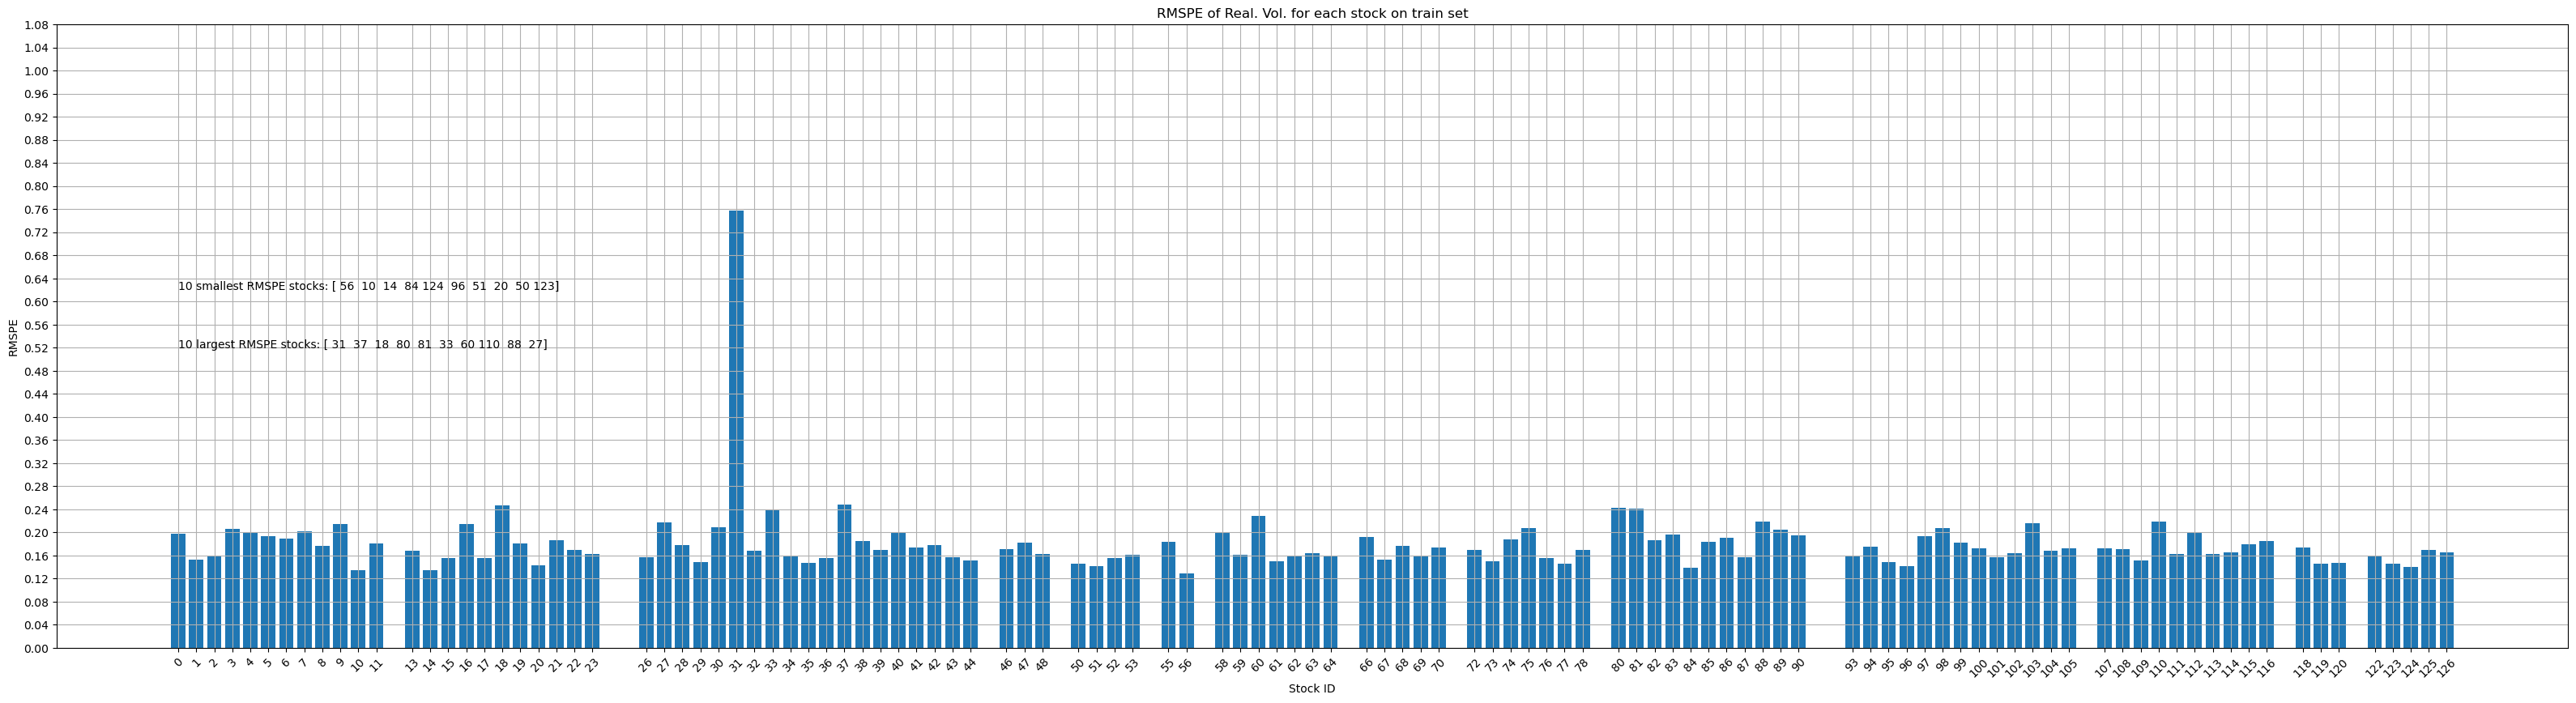


 10_largest_rmspe_stocks in clustering feature

 10_smallest_rmspe_stocks in clustering feature
30_largest_rmspe_stocks in train set:  [ 31  37  18  80  81  33  60 110  88  27 103   9  16  30  75  98   3  89
   7 112  58  40   4   0  83  90   5  97  66  86]


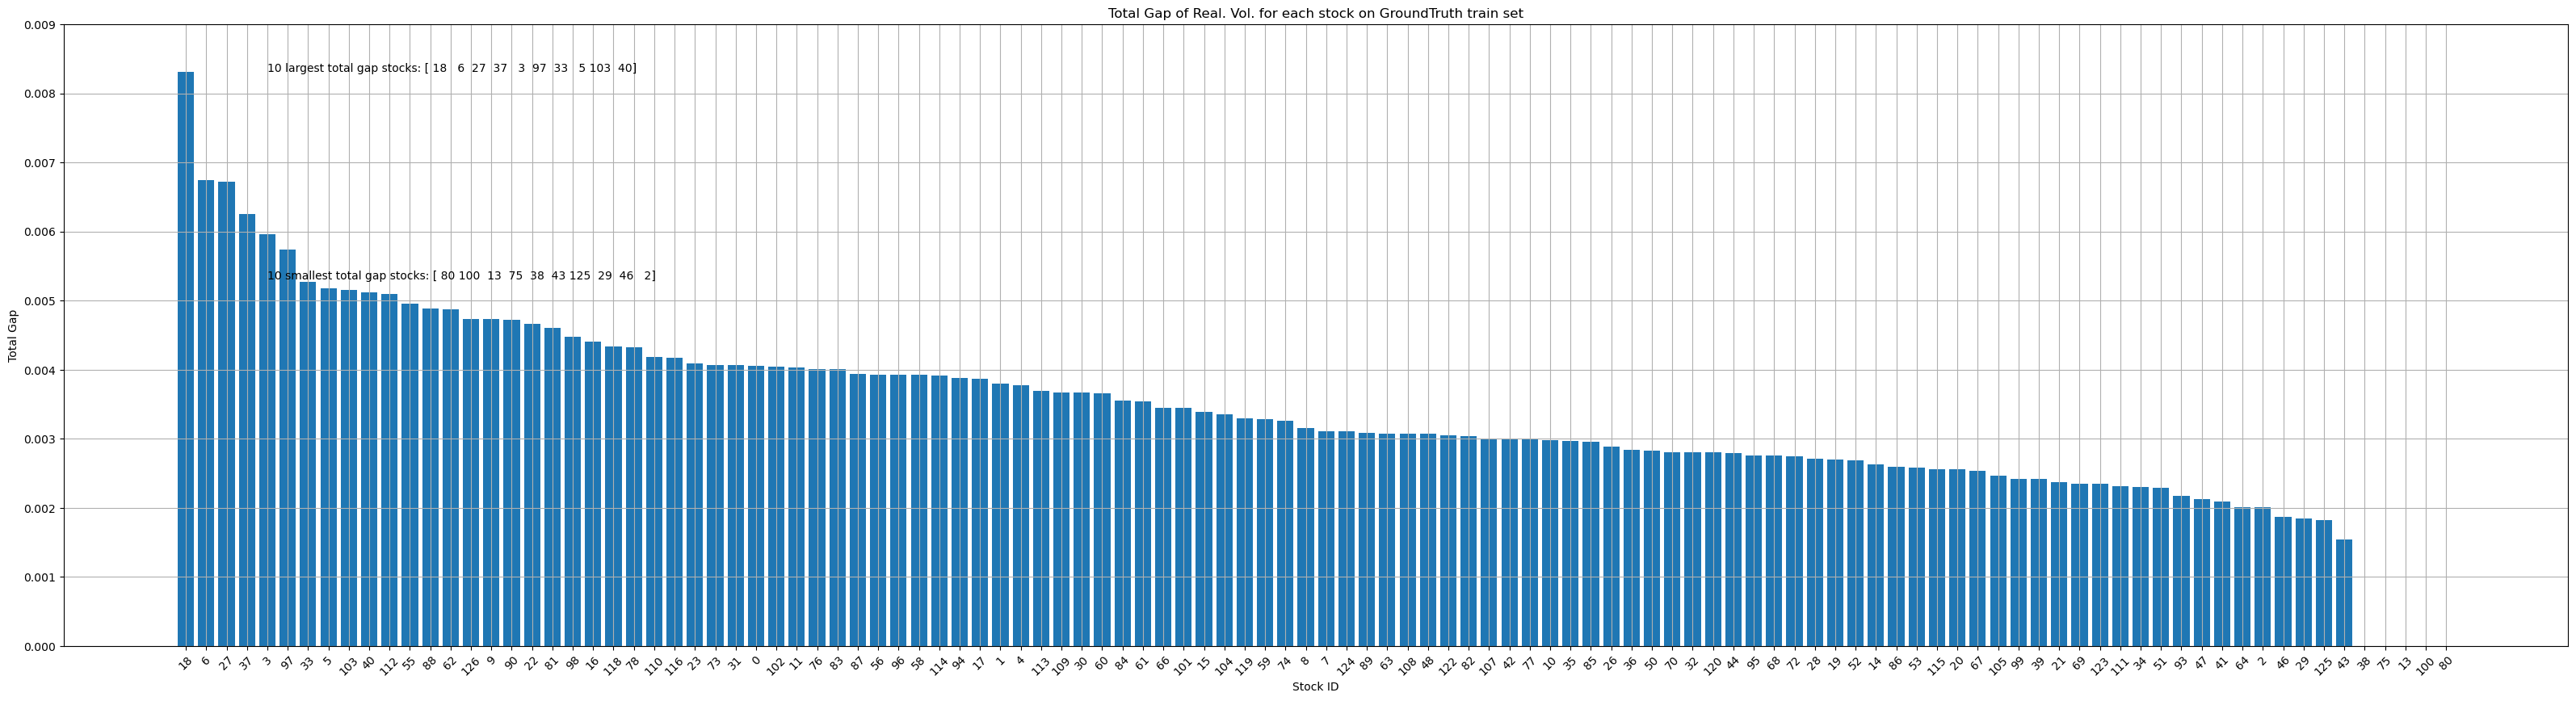

30_largest_total_gap_stocks in train set:  [ 18   6  27  37   3  97  33   5 103  40 112  55  88  62 126   9  90  22
  81  98  16 118  78 110 116  23  73  31   0 102]


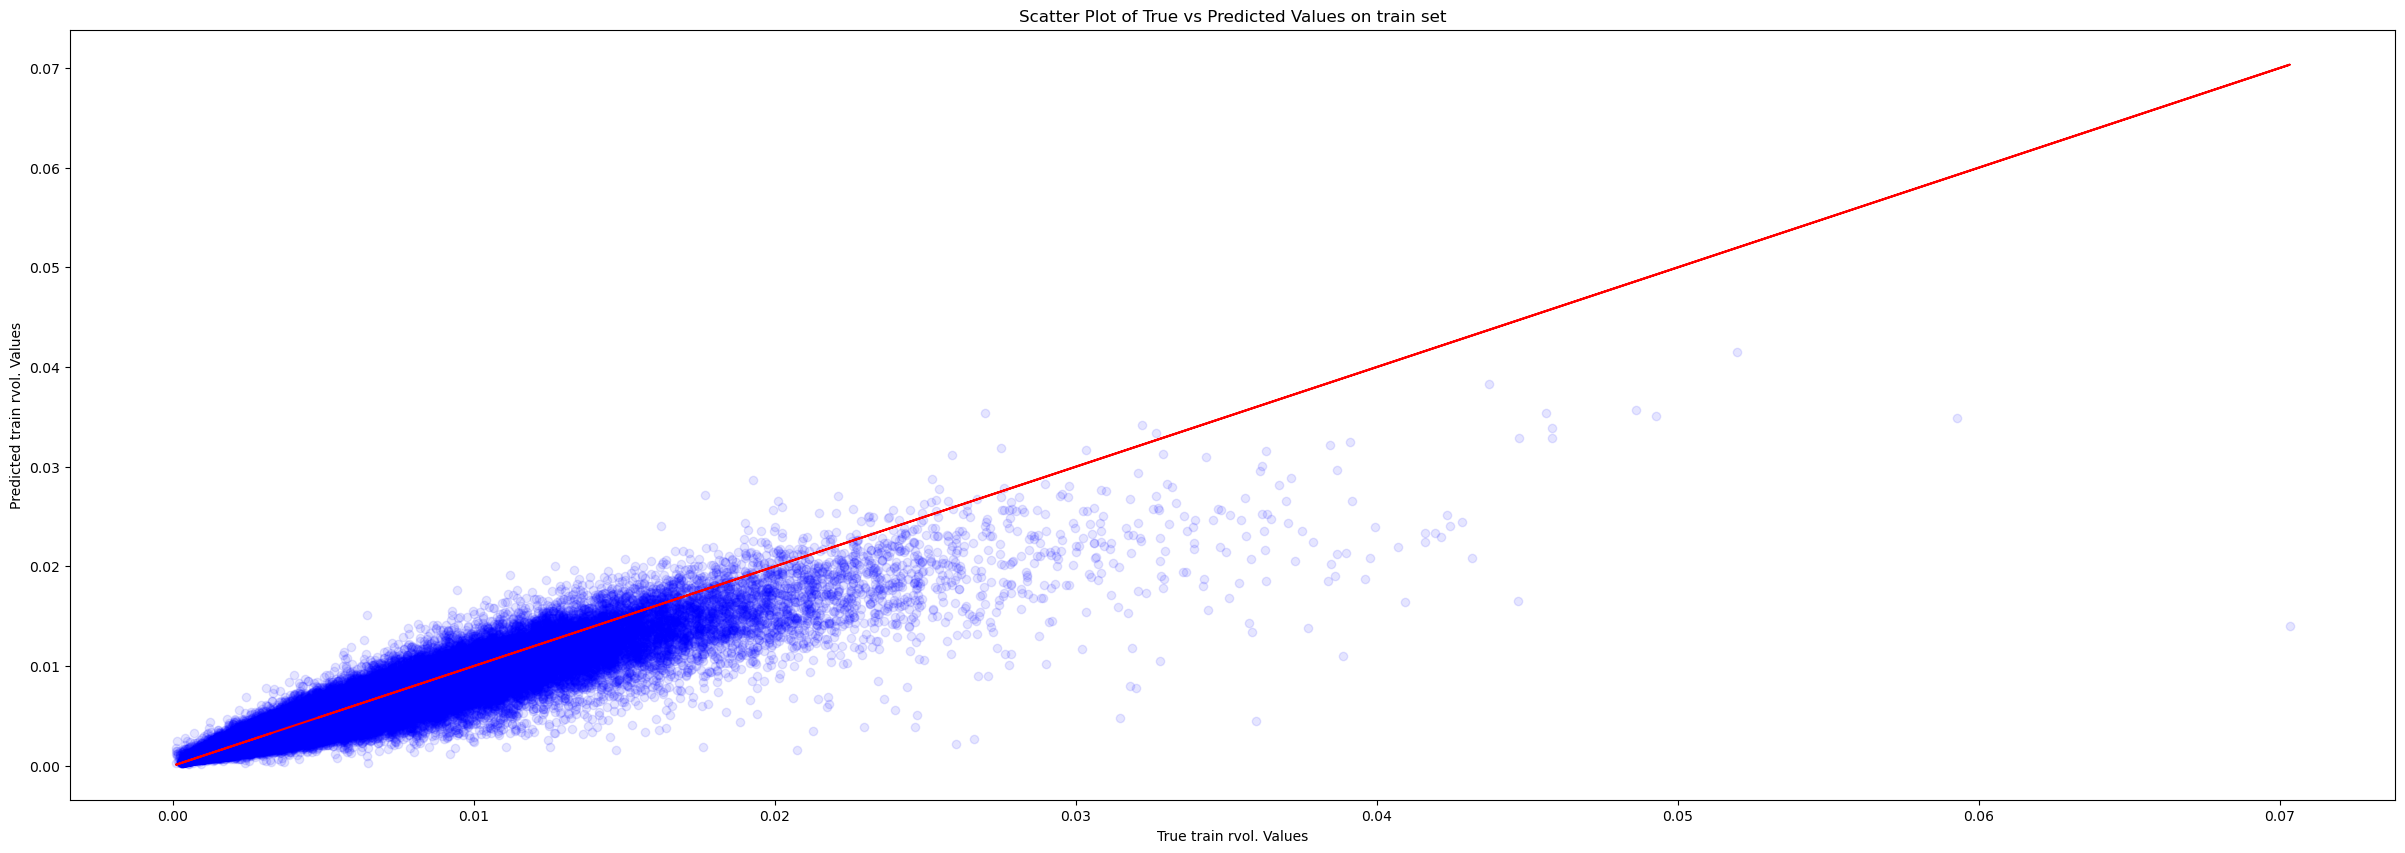

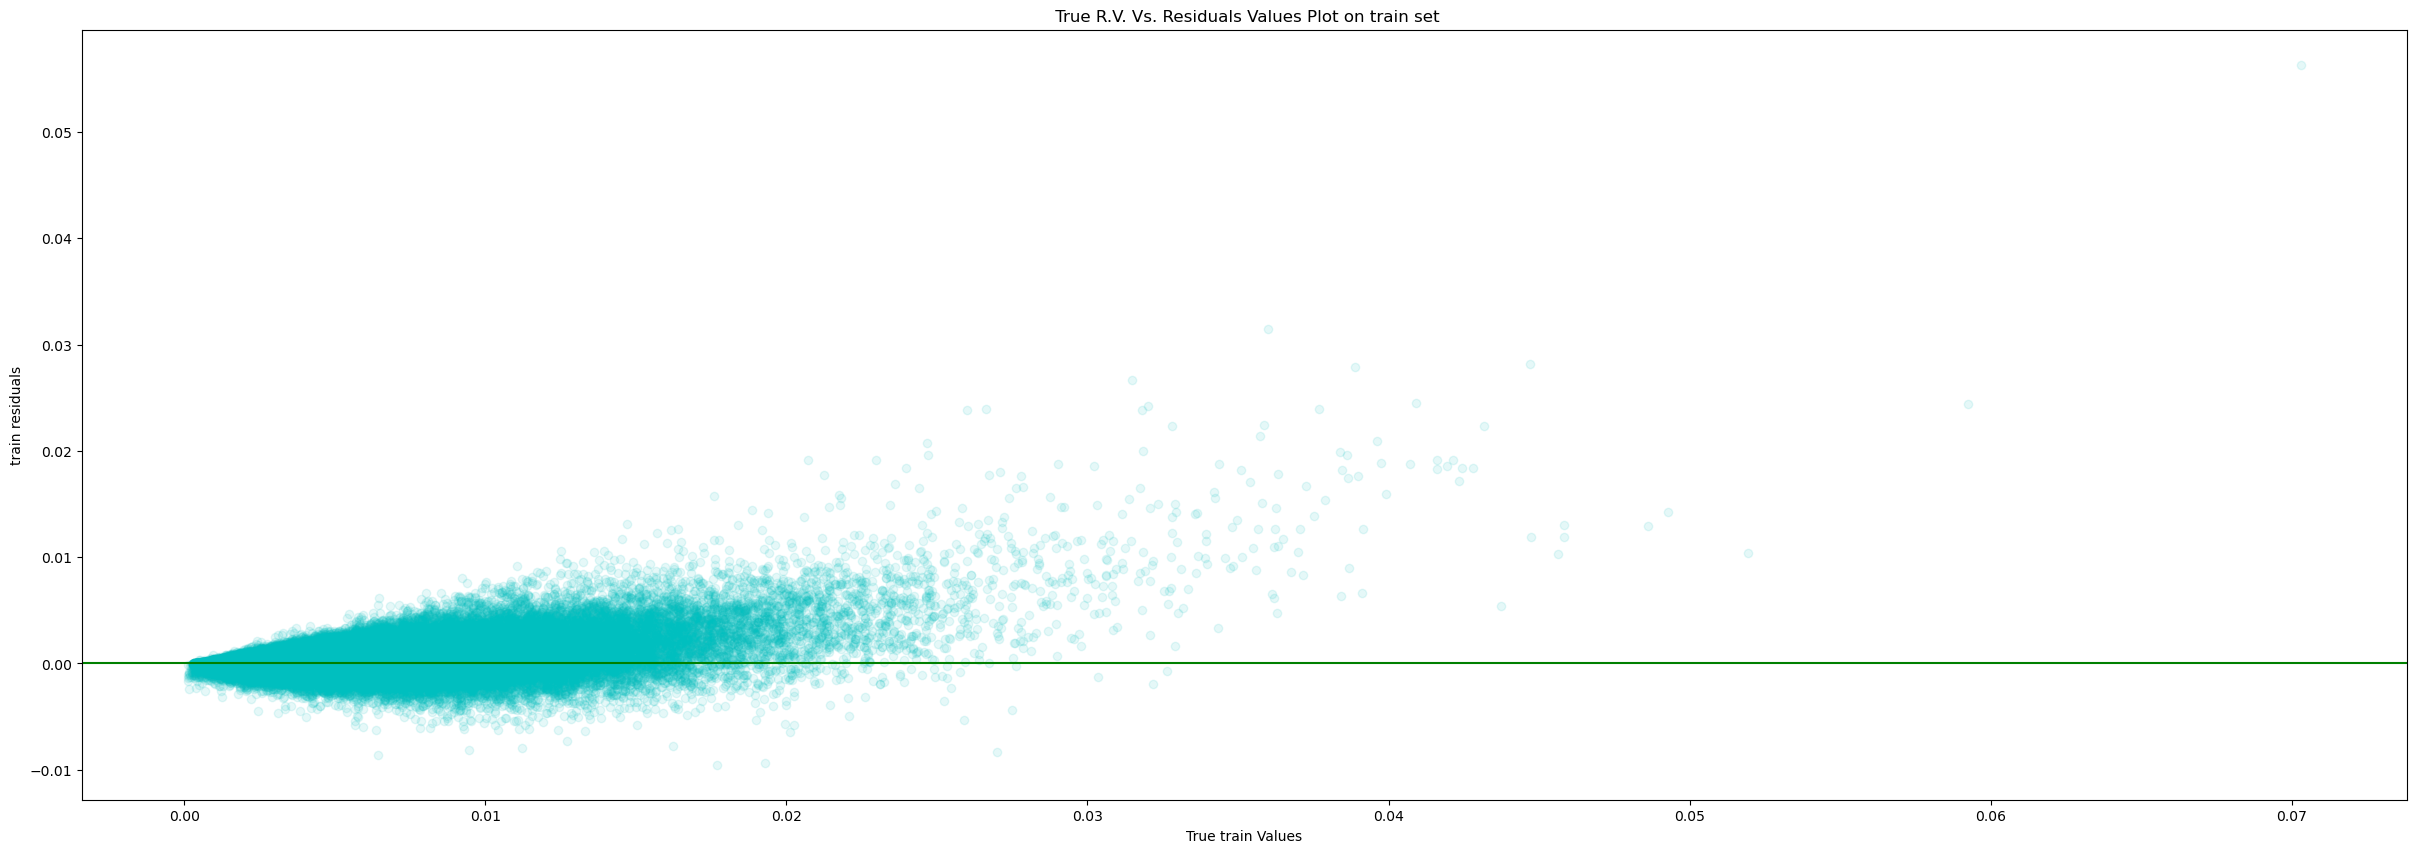

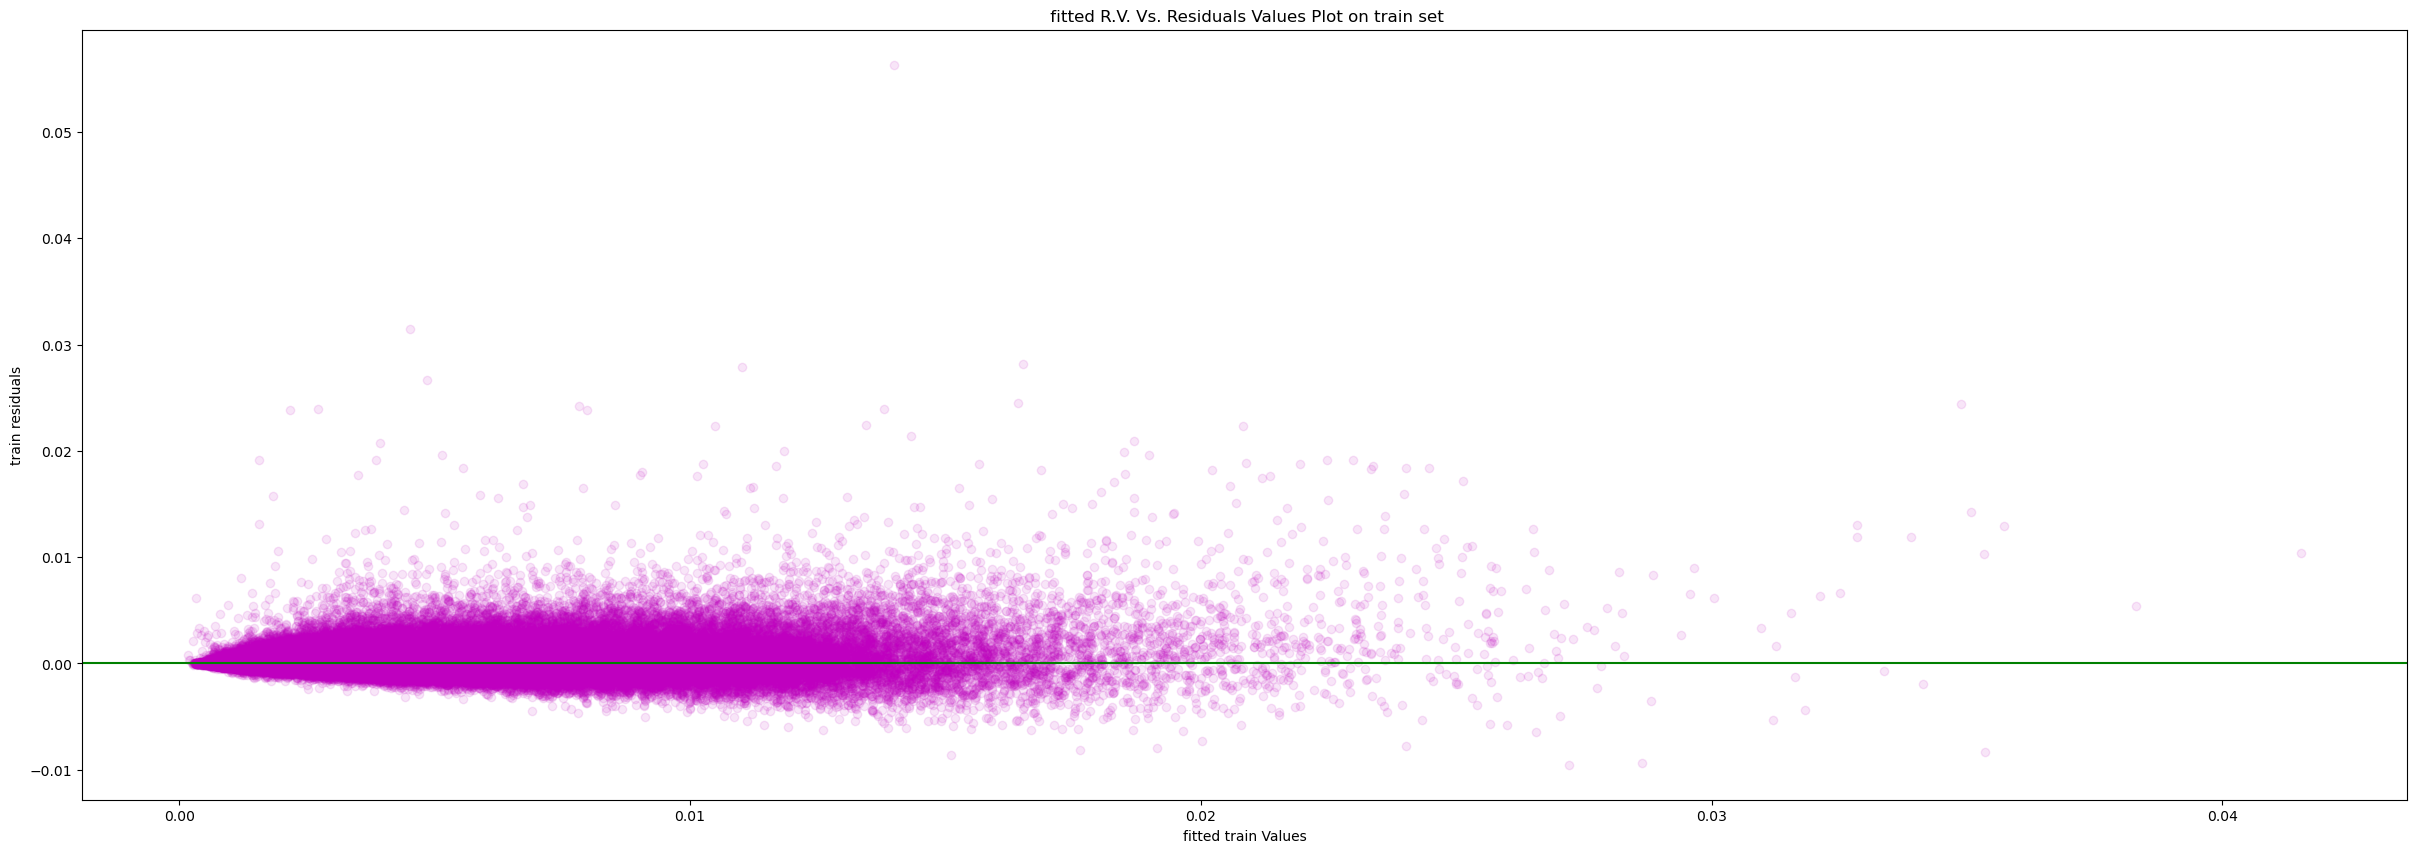

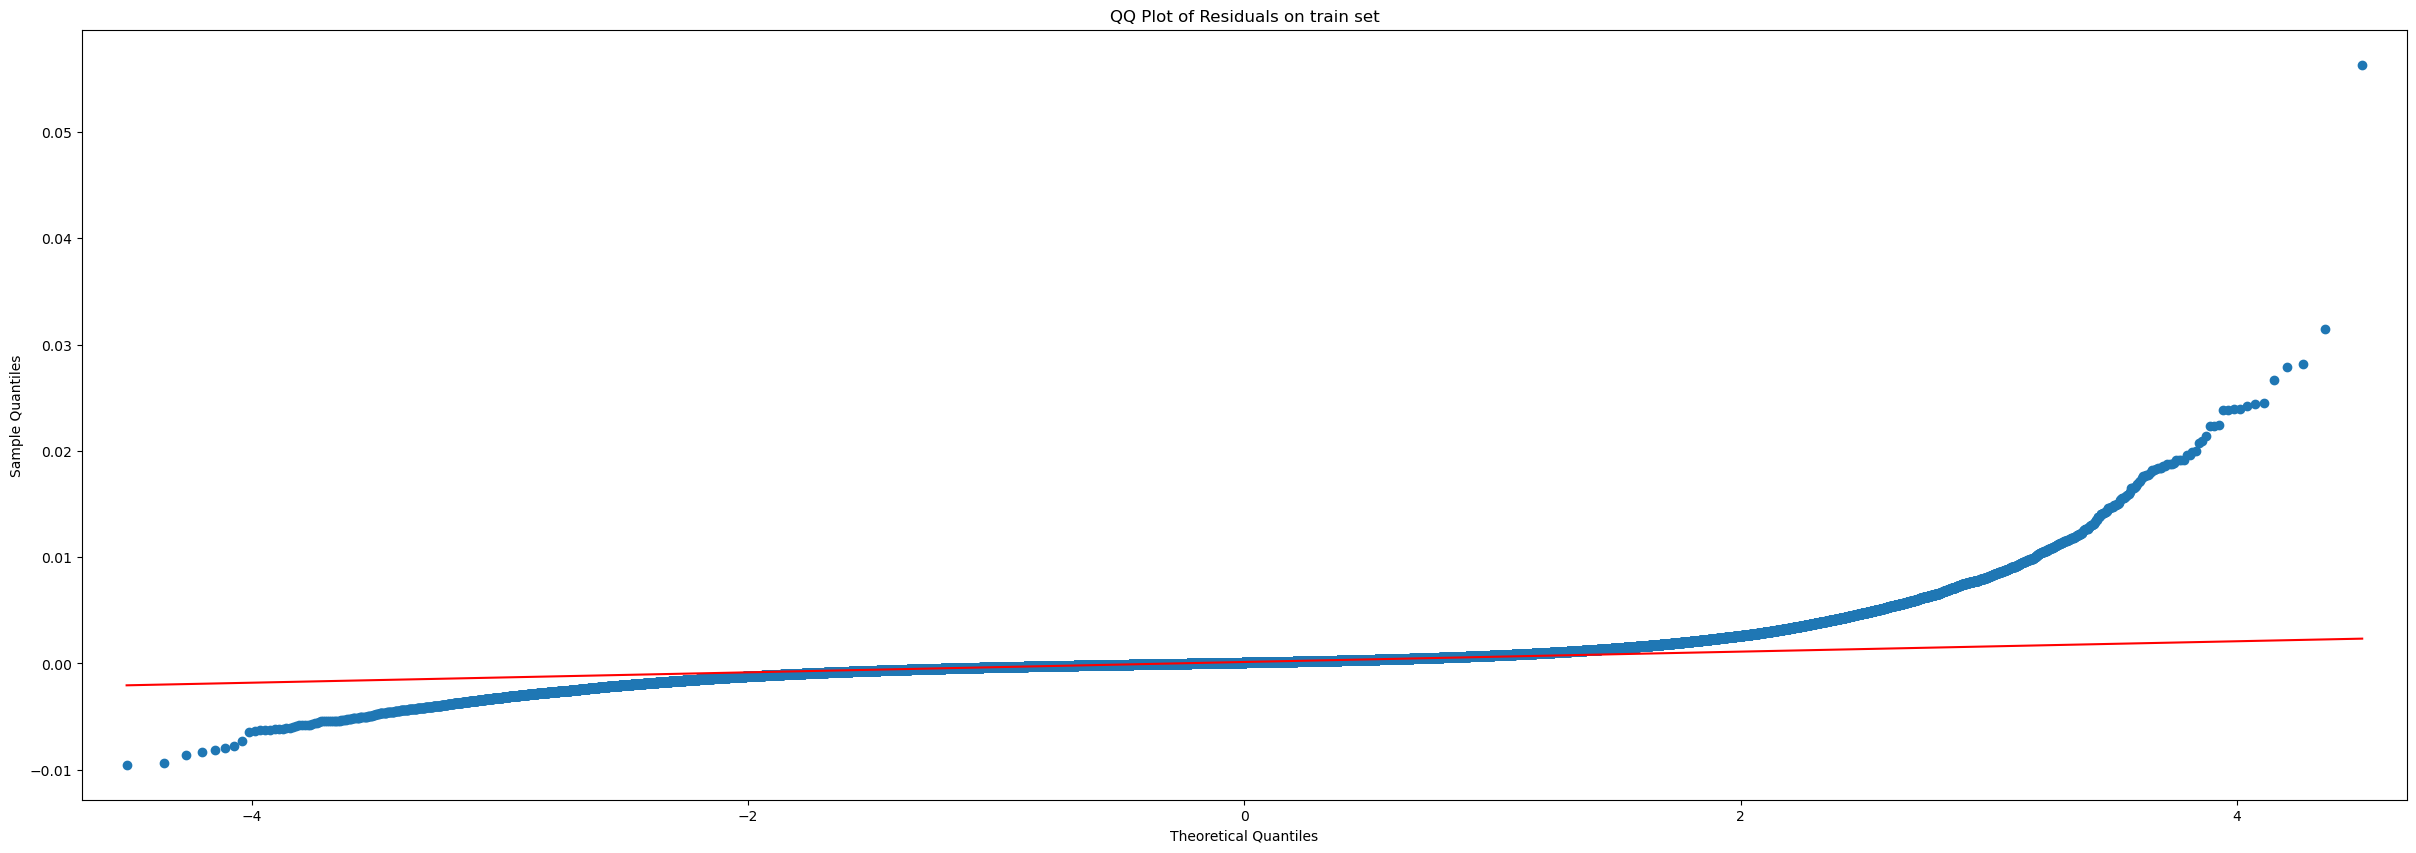

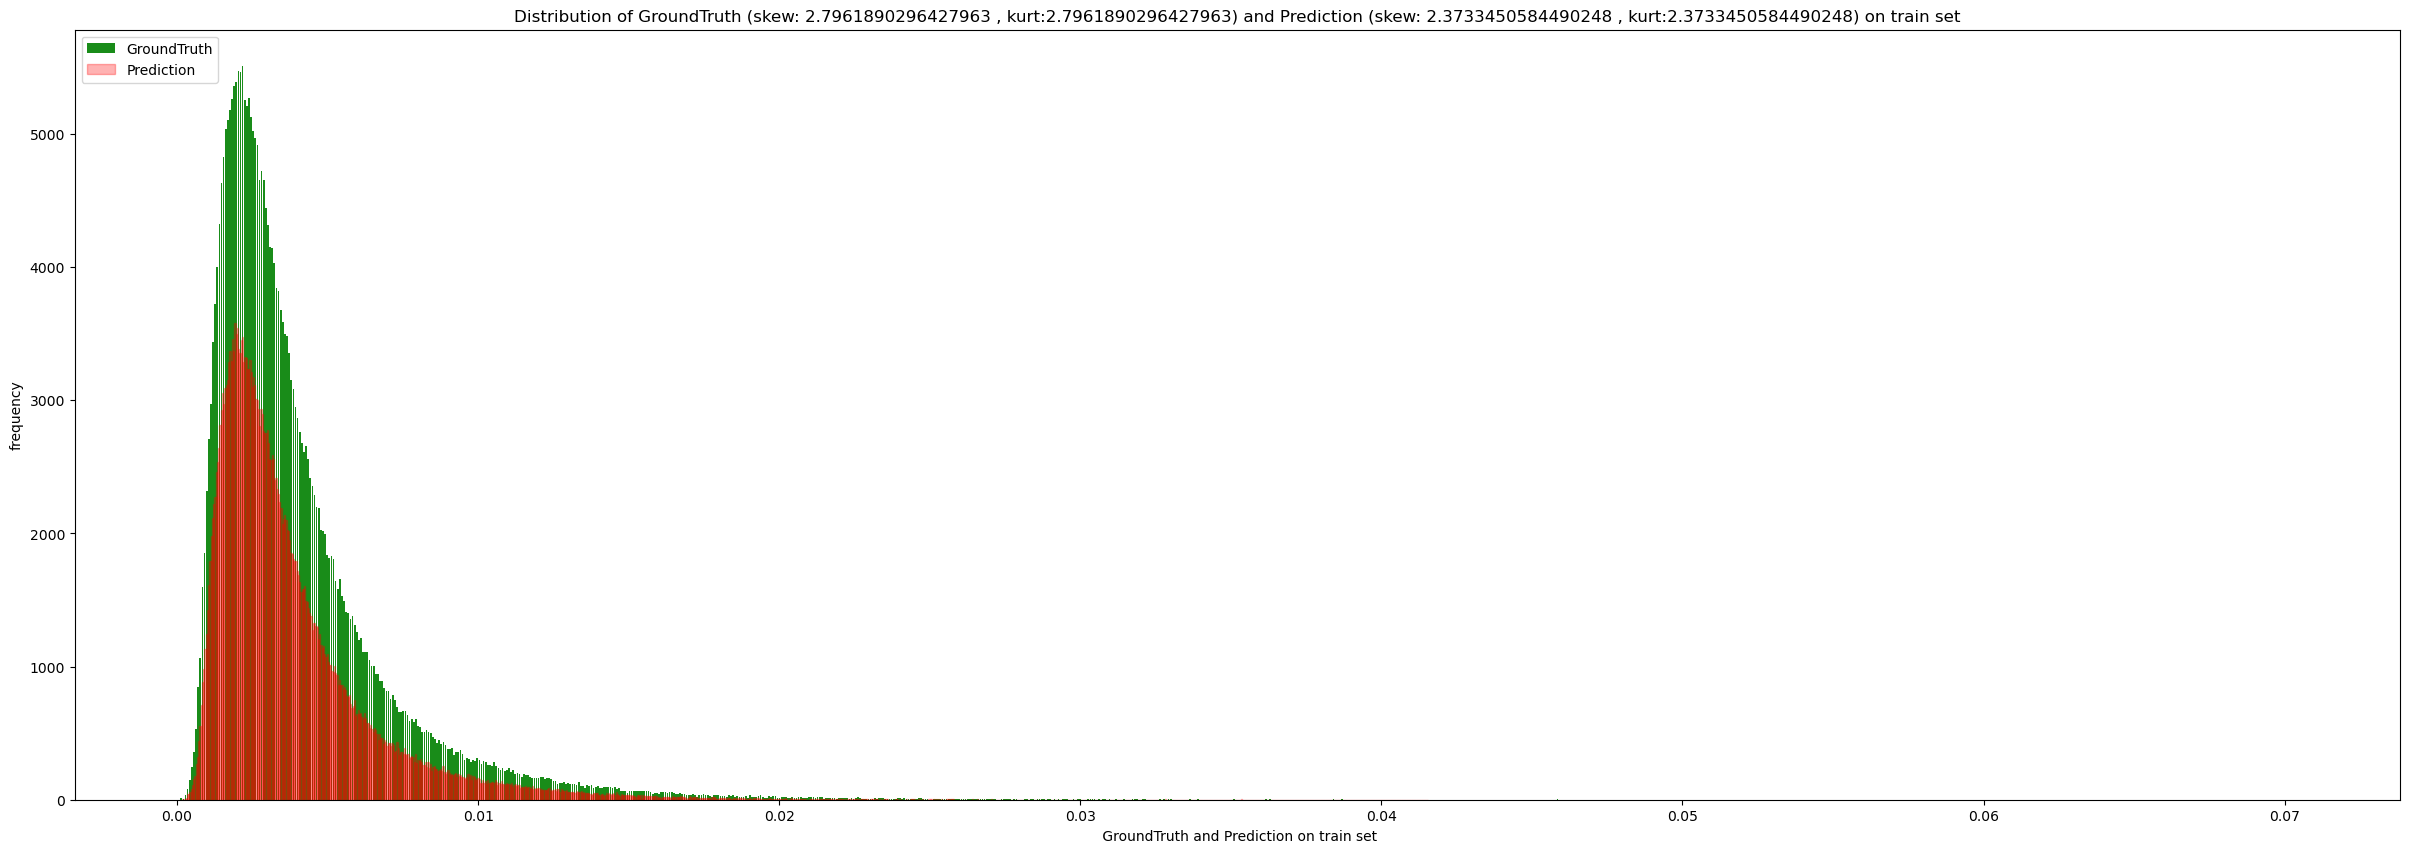

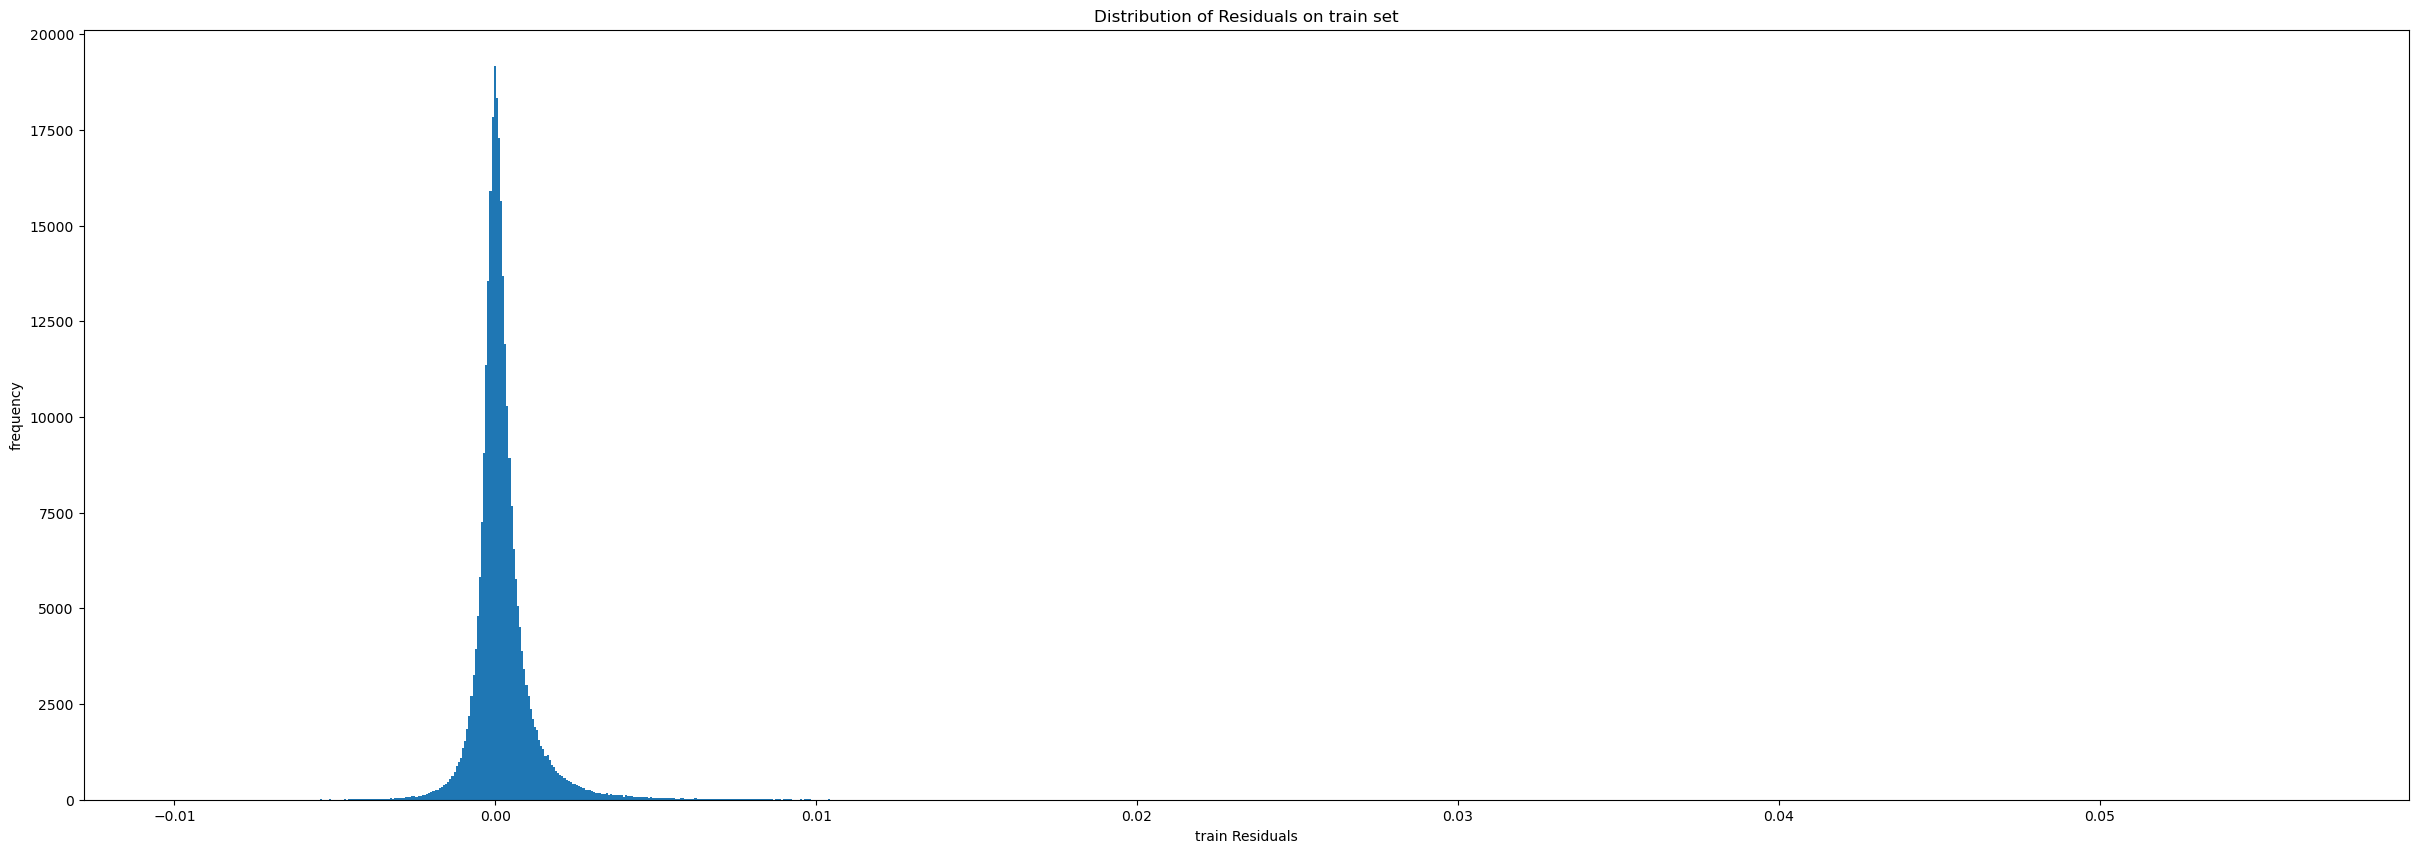


####################################### OVERALL STOCK ANALYSIS END ######################################

############################## INDIVIDUAL STOCK ANALYSIS START #################################

############################## INDIVIDUAL STOCK ANALYSIS END #################################

############################## OVERALL TIME ANALYSIS START #################################

############################## OVERALL TIME ANALYSIS END #################################

###################################### Feature importance & SHAPLEY START #########################################

###################################### Feature importance & SHAPLEY END #########################################

####################################### TRAINING SET predictions END #################################################


####################################### TESTING SET predictions START #################################################

######################################

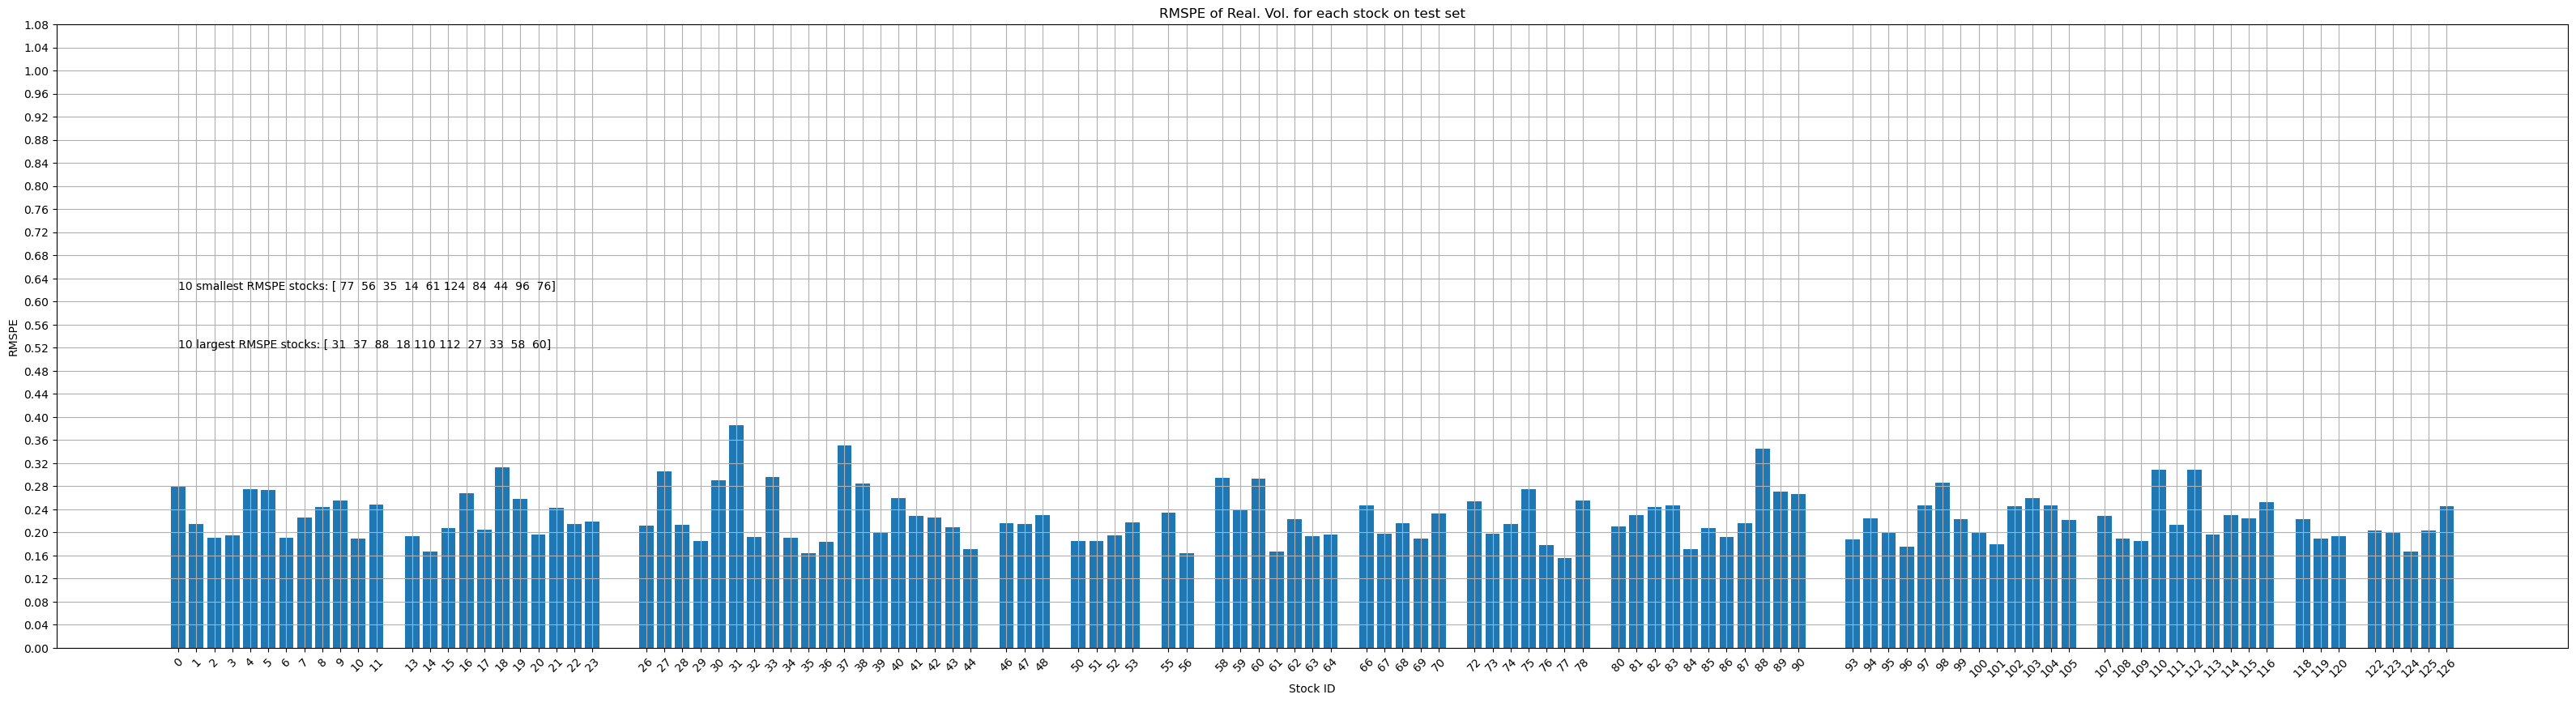


 10_largest_rmspe_stocks in clustering feature

 10_smallest_rmspe_stocks in clustering feature
30_largest_rmspe_stocks in test set:  [ 31  37  88  18 110 112  27  33  58  60  30  98  38   0  75   4   5  89
  16  90 103  40  19   9  78  72 116  11  66 104]


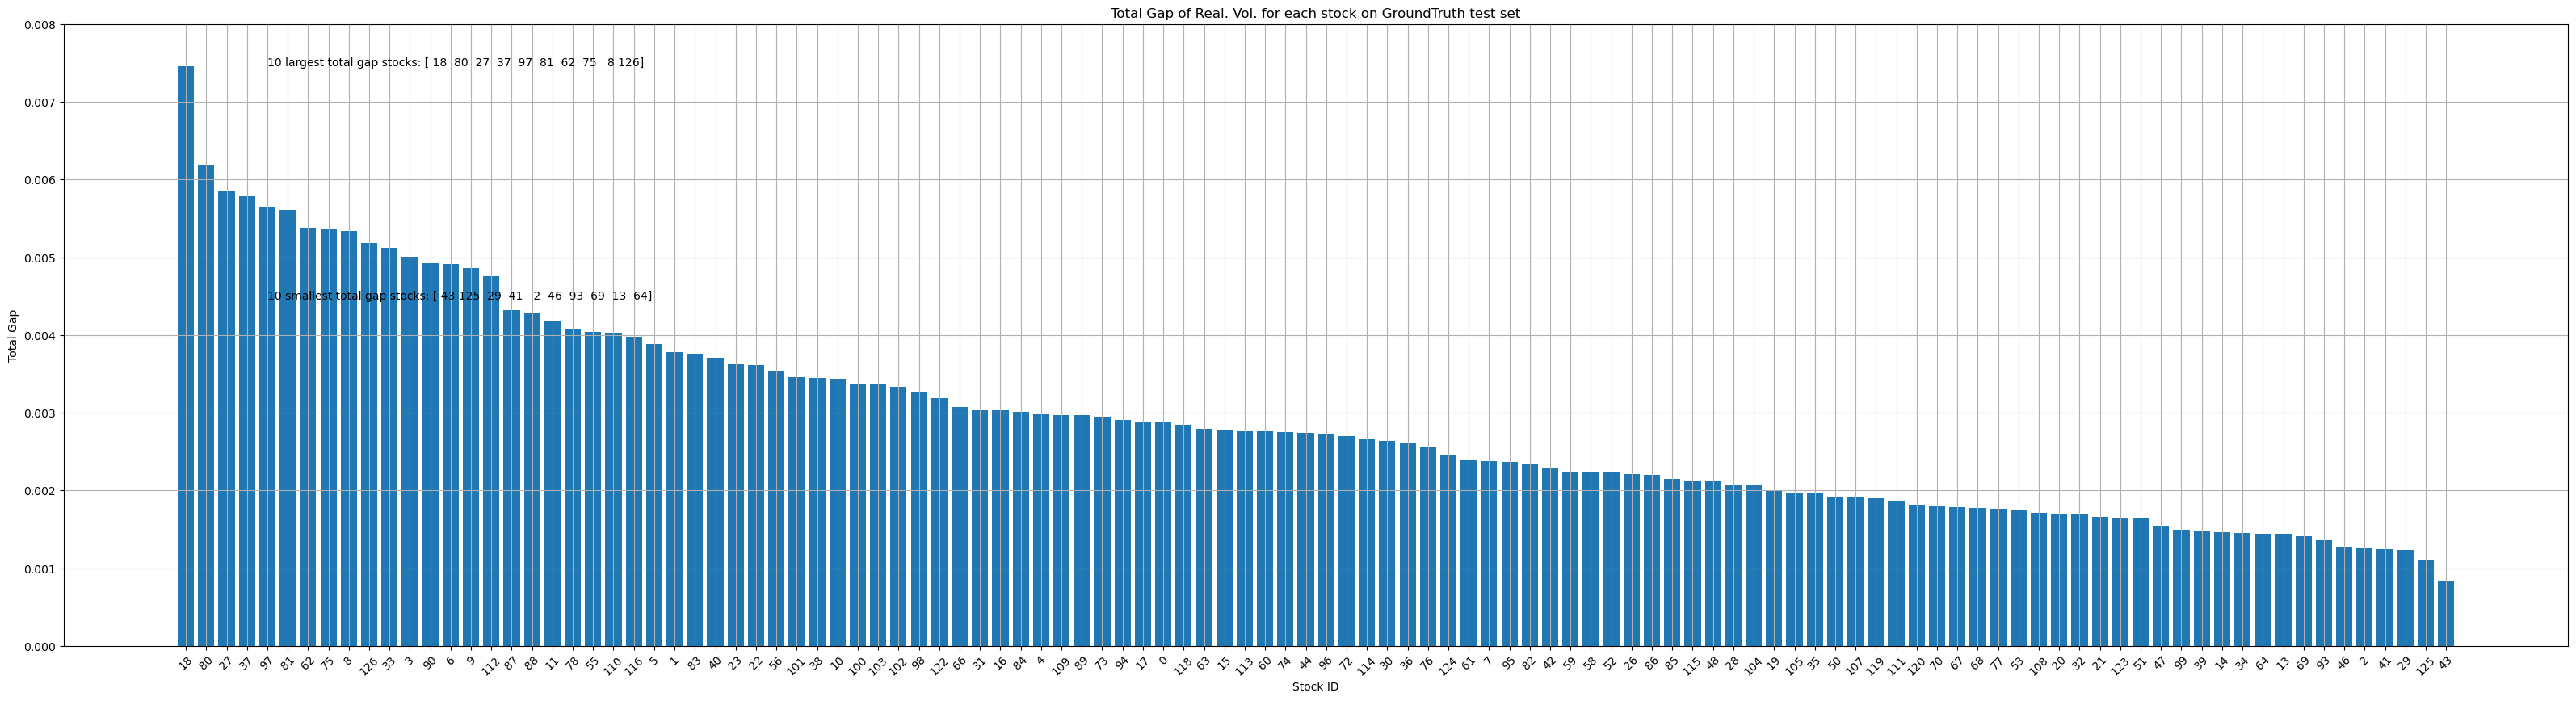

30_largest_total_gap_stocks in test set:  [ 18  80  27  37  97  81  62  75   8 126  33   3  90   6   9 112  87  88
  11  78  55 110 116   5   1  83  40  23  22  56]


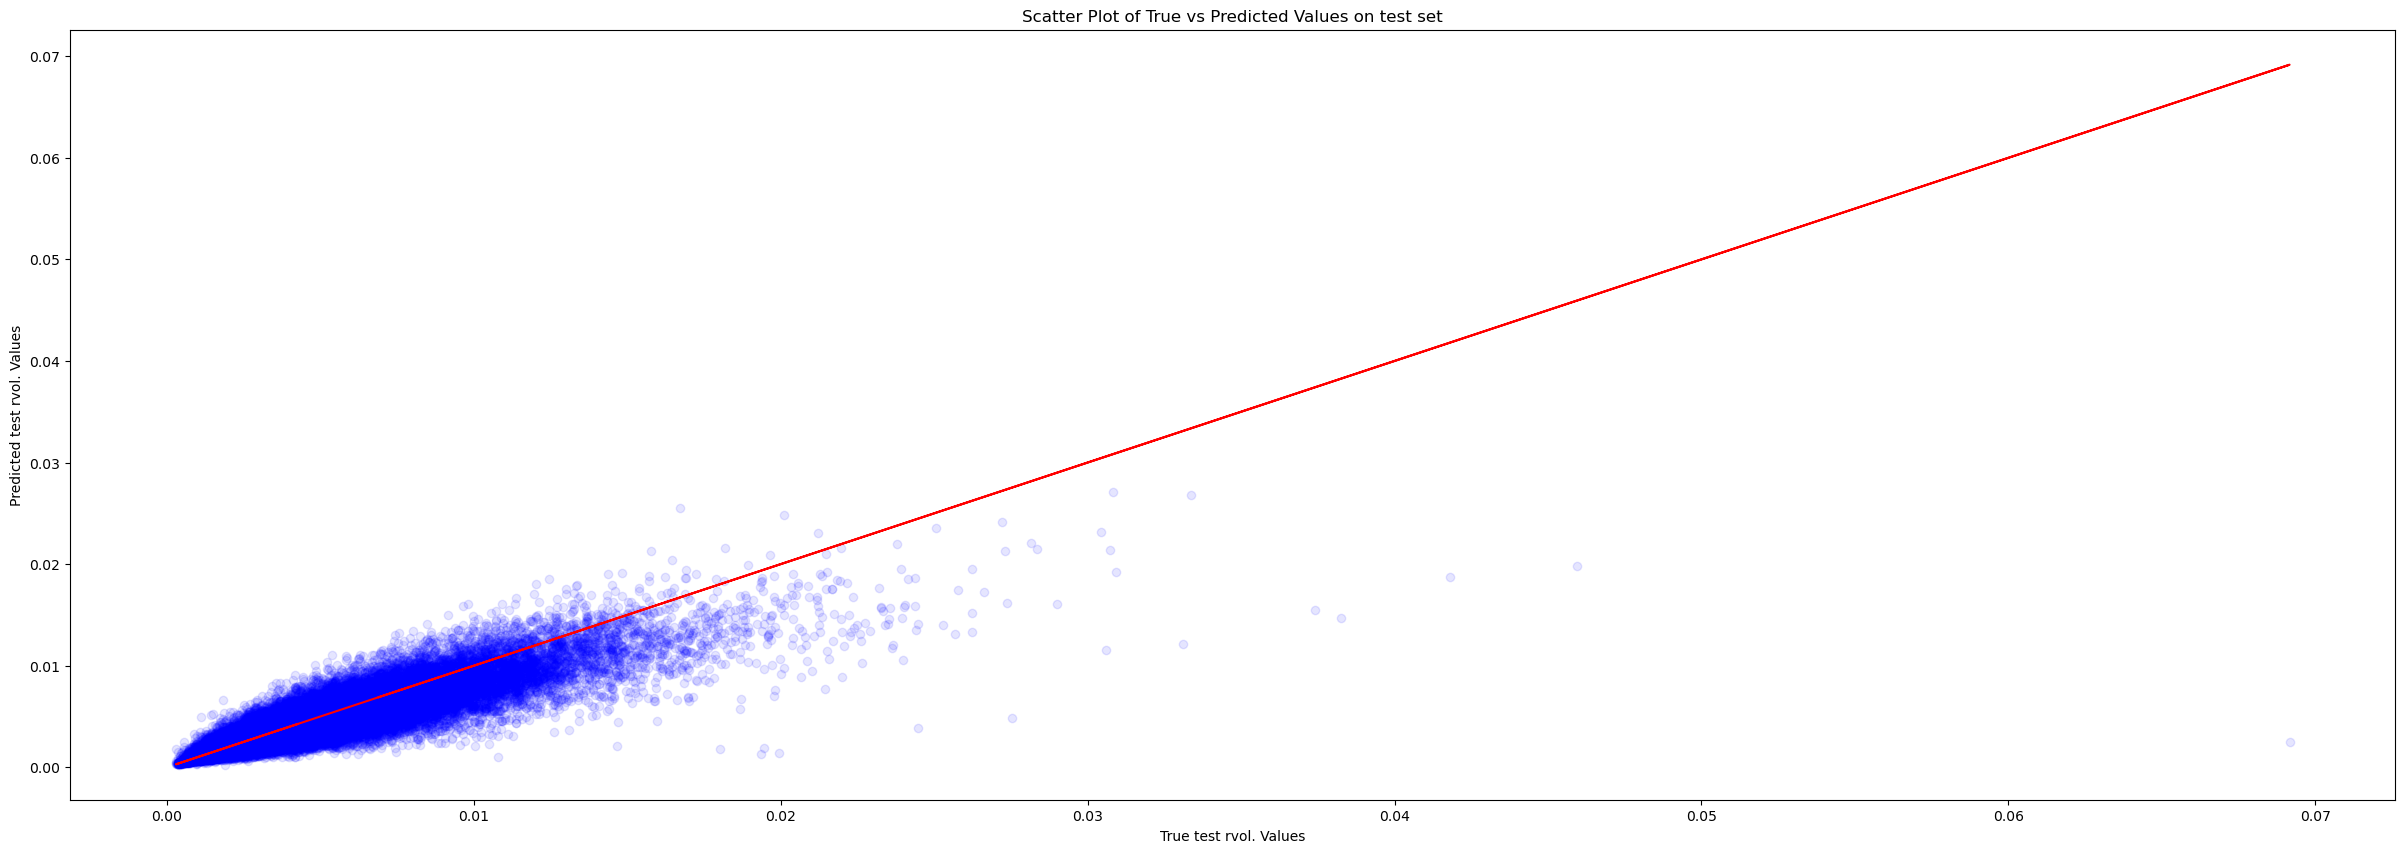

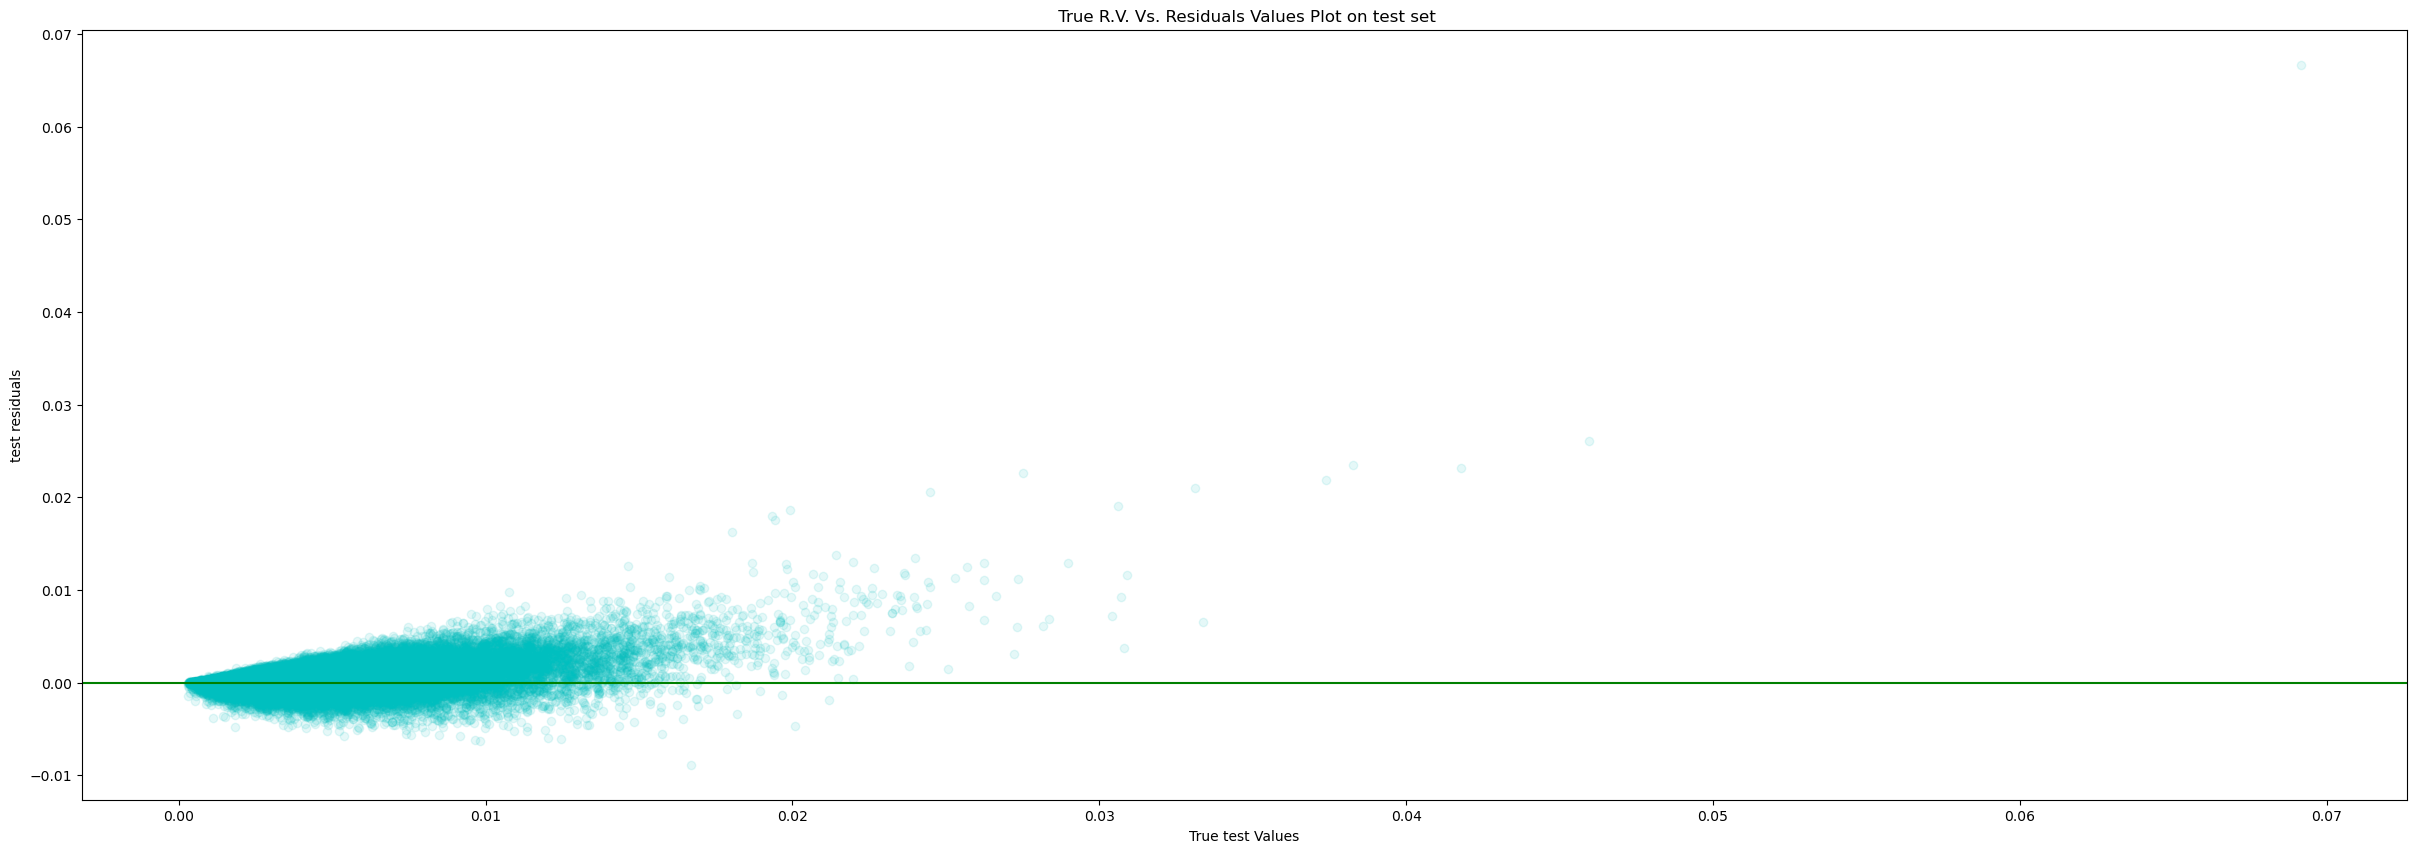

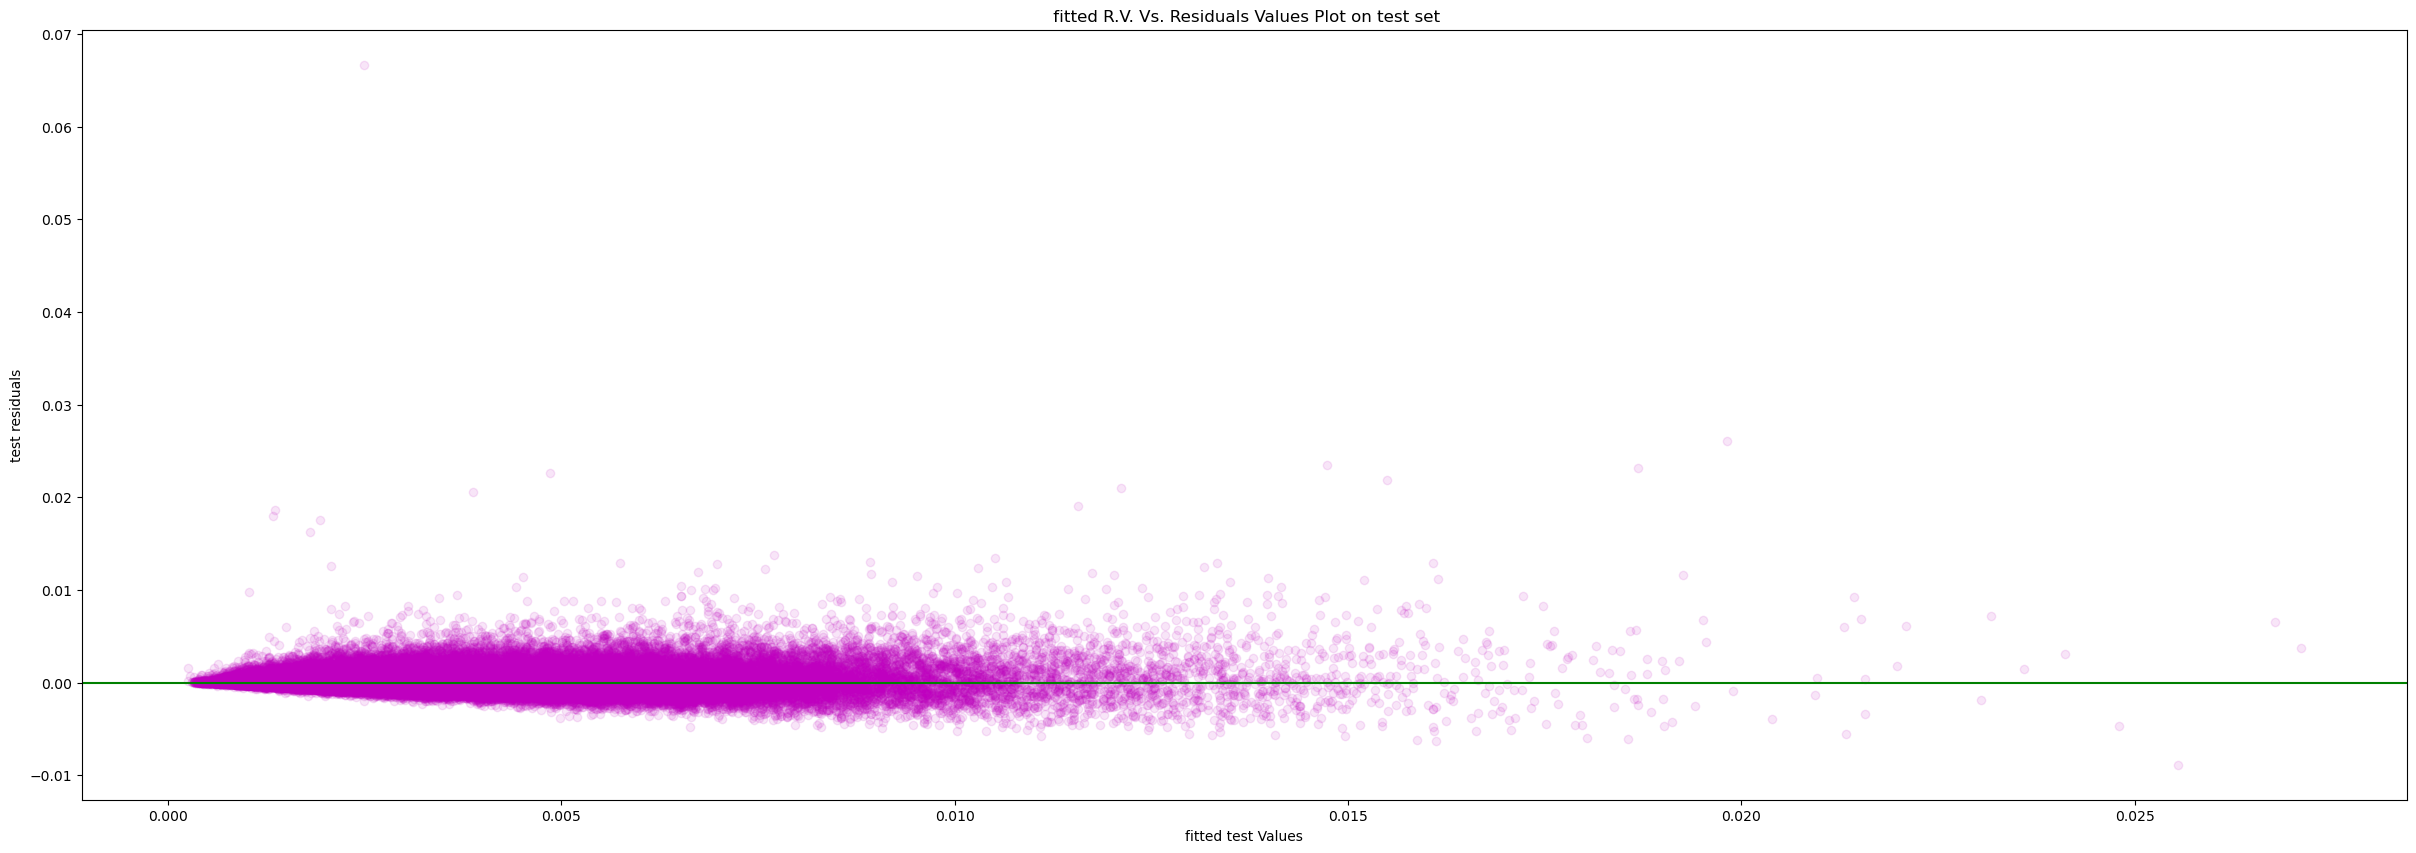

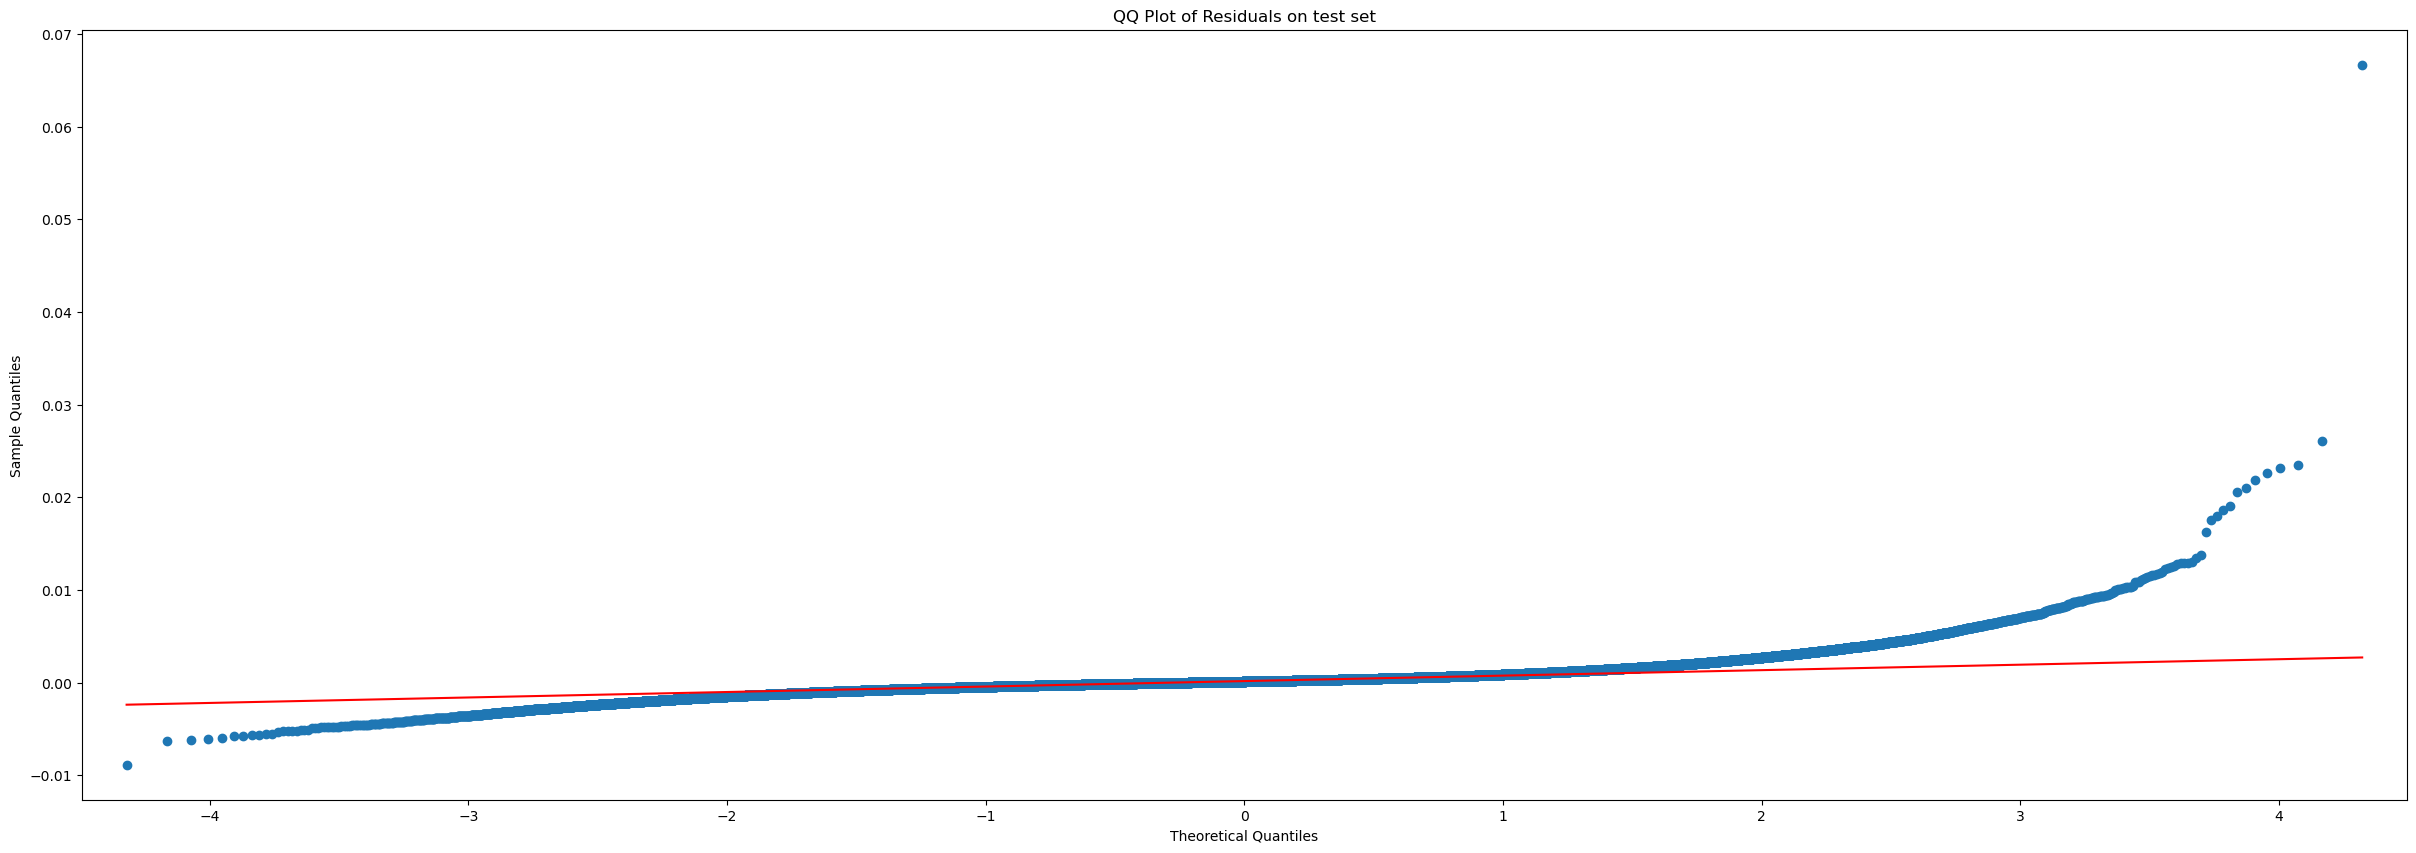

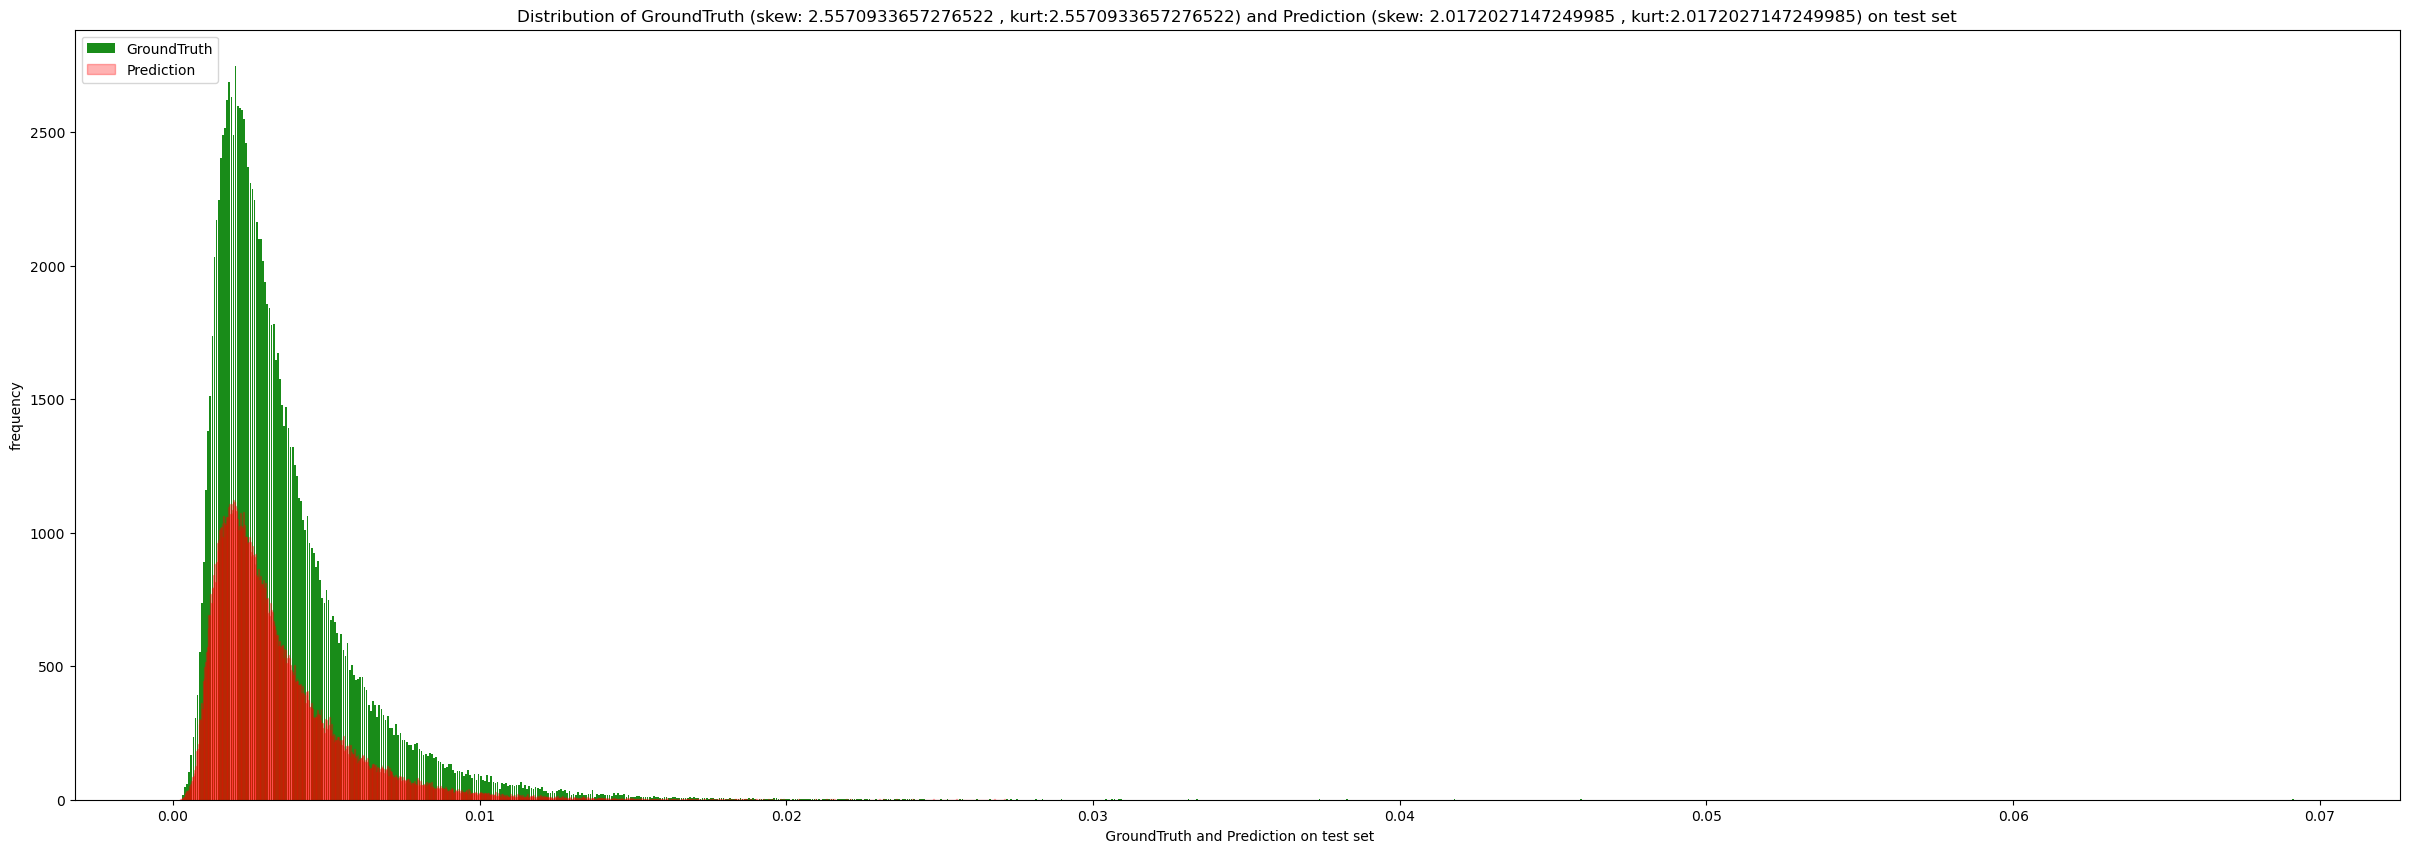

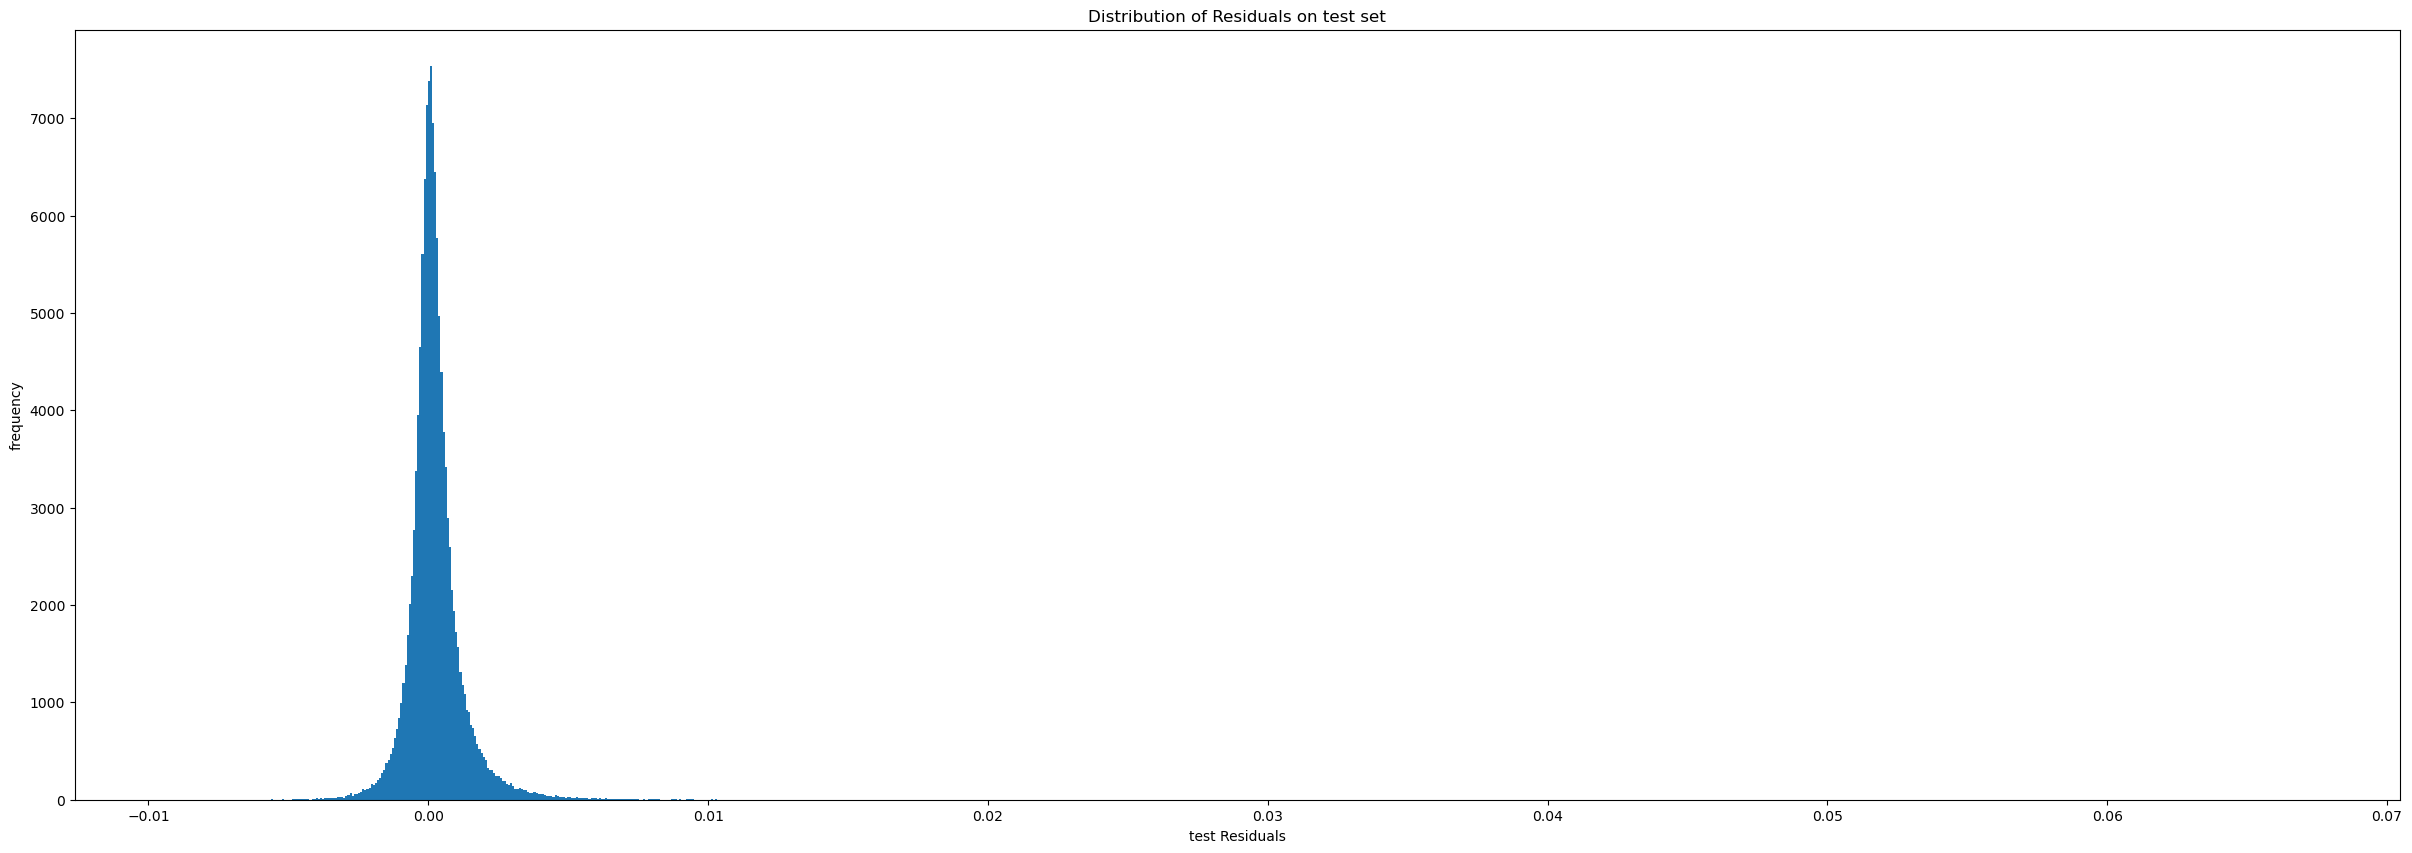


####################################### OVERALL STOCK ANALYSIS END ######################################

############################## INDIVIDUAL STOCK ANALYSIS START #################################

############################## INDIVIDUAL STOCK ANALYSIS END #################################
##################################################################################################

####################################### TESTING SET predictions END #################################################


####################################### TRAINING AND TESTING SET PERFORMANCE COMPARISON START #################################################
##################################################################################################

####################################### TRAINING AND TESTING SET PERFORMANCE COMPARISON END #################################################



In [335]:

seed1 = 11
missing_value = -np.inf  # Replace with a suitable value


############ Best parameters Manual Start ############
num_rounds = 1135 #838 #study.trials[trial.number].user_attrs['best_iteration']
max_depth = 17
eta =  0.012302593098587278
subsample =  0.75
colsample_bytree =  0.8
gamma = 0
reg_alpha =  11
reg_lambda = 8
min_child_weight =  6
############ Best parameters Manual End ############

############ Best parameters Automatic Start ############
# best_trial = study.best_trial
# num_rounds = study.best_trial.user_attrs['best_iteration']
# print('final best iteration: ',num_rounds )
# seed1 = 11
# missing_value = -np.inf  # Replace with a suitable value
# max_depth = best_trial.params['max_depth']
# eta =  best_trial.params['eta']
# subsample =  best_trial.params['subsample']
# colsample_bytree =  best_trial.params['colsample_bytree']
# gamma =  best_trial.params['gamma']
# reg_alpha =  best_trial.params['reg_alpha']
# reg_lambda = best_trial.params['reg_lambda']
# min_child_weight = best_trial.params['min_child_weight']
############ Best parameters Automatic End ############





best_mlxtend_xgb_params = [max_depth,eta,subsample,colsample_bytree,gamma,reg_alpha,reg_lambda,min_child_weight,num_rounds]

best_params = { 'disable_default_eval_metric': 1,
              "max_depth": max_depth,
            "eta": eta,
            "subsample" : subsample,
            "colsample_bytree":  colsample_bytree,
            'gamma':gamma,
            'reg_alpha': reg_alpha,
            'reg_lambda': reg_lambda,
            'min_child_weight': min_child_weight,
            "tree_method": 'hist',
            "device": "cuda",
            "seed":seed1,
            #'missing': missing_value
               }

t_v_t = train_validate_n_test(df_train_reordered, df_test)
#final_reg,test_pred,train_pred,y_train,X_train,X_test,v1tr,w_train = t_v_t.make_predictions(best_params,num_rounds)


train_pred = pd.DataFrame(train_pred).rename(columns={'log_wap1_log_price_ret_vol':'target'})
train_pred['time_id'] = df_train_reordered['time_id']
train_pred['stock_id'] = df_train_reordered['stock_id']

y_train = pd.DataFrame(y_train).rename(columns={'log_wap1_log_price_ret_vol':'target'})
y_train['time_id'] = df_train_reordered['time_id']
y_train['stock_id'] = df_train_reordered['stock_id']

v1tr = pd.DataFrame(v1tr)
v1tr['time_id'] = df_train_reordered['time_id']
v1tr['stock_id'] = df_train_reordered['stock_id']

test_pred = pd.DataFrame(test_pred).rename(columns={'log_wap1_log_price_ret_vol':'target'})
test_pred['time_id'] = df_test['time_id'].astype(int)
test_pred['stock_id'] = df_test['stock_id'].astype(int)

## # Merge the DataFrames on 'time_id' and 'stock_id' columns
os.chdir('/home/optimusprime/Desktop/peeterson/optiver/Optiver-Realized-Volatility-Prediction/data')
train = pd.read_csv('train.csv')
X_test['time_id'] = df_test['time_id']
y_test_df = pd.merge(X_test[['time_id', 'stock_id']], train[['time_id', 'stock_id', 'target']], on=['time_id', 'stock_id'], how='left')
y_test_df['time_id'] = df_test['time_id'].astype(int)
y_test_df['stock_id'] = df_test['stock_id'].astype(int)

t_v_t.evaluate_predictions(final_reg,test_pred, y_test_df,train_pred,y_train, X_train,v1tr,w_train,best_mlxtend_xgb_params)



# del final_reg,test_pred, y_test,train_pred,y_train,X_train,X_test,v1tr,w_train
# gc.collect()

# ## save the best model with timestamp for future use.
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# filename = f'xgb_gpu_{timestamp}.pkl'
# os.chdir('/content/drive/MyDrive/optiver_real_vol/Xgboost_gpu_models/xgb_gpu_model_registry')
# with open(filename, 'wb') as file:
#     pickle.dump(final_reg, file)
# print(f'Model saved to: {filename}')
# os.chdir('/content/drive/MyDrive/optiver_real_vol/Datasets/liquidity_features')


# del study, trial,t_v_t,final_reg,test_pred, y_test,train_pred,y_train
# gc.collect()


In [341]:
largest_rmspe_stocks = ' 31  37  88  18 110 112  27  33  58  60  30  98  38   0  75   4   5  89  16  90 103  40  19   9  78  72 116  11  66 104'

largest_total_gap_stocks = '18  80  27  37  97  81  62  75   8 126  33   3  90   6   9 112  87  88   11  78  55 110 116   5   1  83  40  23  22  56'


largest_rmspe_stocks = largest_rmspe_stocks.split()
largest_total_gap_stocks = largest_total_gap_stocks.split()

len(set(largest_rmspe_stocks) & set(largest_total_gap_stocks))

15